# There is no plan bee without them 🐝

## Abstract

Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honey bees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As hand-pollination is currently not an alternative, it is hard to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of the population of bees, as well as the honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using surveys from the [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to showcase the essential role of honey bees in our agriculture.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013

## Disclaimer

There are a lot of different pollinator species in danger; however, we will only focus on commercial honey bees. All the data gathered about them obviously excludes wild populations since we deal with agricultural data. We found no surveys about wild populations.

In [1]:
# Python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import json
import re
import matplotlib
import plotly
from plotly.subplots import make_subplots
from plotly.graph_objects import layout
%matplotlib inline

matplotlib.rc('font', **{'size': 12}) # Text more readable

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Our first goal is to plot the evolution of the number of beehives per continent. For this purpose, we use the dataset from FAOSTAT listing the number of beehives per country from 1961.

In [2]:
beehives_raw = pd.read_csv('data/FAOSTAT_Live_Stock.csv')
beehives_raw.head()

Domain Code        Domain  Area Code     Area  Element Code Element  \
0          QA  Live Animals          3  Albania          5114  Stocks   
1          QA  Live Animals          3  Albania          5114  Stocks   
2          QA  Live Animals          3  Albania          5114  Stocks   
3          QA  Live Animals          3  Albania          5114  Stocks   
4          QA  Live Animals          3  Albania          5114  Stocks   

   Item Code      Item  Year Code  Year Unit     Value Flag Flag Description  
0       1181  Beehives       1961  1961   No   95100.0  NaN    Official data  
1       1181  Beehives       1962  1962   No   92800.0  NaN    Official data  
2       1181  Beehives       1963  1963   No   83500.0  NaN    Official data  
3       1181  Beehives       1964  1964   No   96500.0  NaN    Official data  
4       1181  Beehives       1965  1965   No  109800.0  NaN    Official data

Let's only select the columns that interest us, i.e. everything apart from the country, the year and the number of beehives.

In [3]:
beehives_raw = beehives_raw[['Area', 'Year', 'Value']]
beehives_raw.head()

Area  Year     Value
0  Albania  1961   95100.0
1  Albania  1962   92800.0
2  Albania  1963   83500.0
3  Albania  1964   96500.0
4  Albania  1965  109800.0

Then, let's import a small dataset that lists all the countries in the world to their respective continents. The csv file was [found here](https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv) and saved in the folder `data` as `countries.csv`.

In [4]:
countries = pd.read_csv('data/countries.csv')
# We only want the name of the country and its continent
countries = countries[['name', 'region']].set_index('name')
print('Are the countries in the dataset unique? -> %s' % countries.index.is_unique)
countries.head()

Are the countries in the dataset unique? -> True


region
name                   
Afghanistan        Asia
Åland Islands    Europe
Albania          Europe
Algeria          Africa
American Samoa  Oceania

The `countries` dataset does not have data from certain countries present in the FAOSTAT dataset. These countries have either ceased to exist (USSR, Yugoslavia, ...), or were defined differently (China, mainland, ...). Let's add them manually.

In [5]:
countries.loc['Belgium-Luxembourg'] = 'Europe'
countries.loc['China, mainland'] = 'Asia'
countries.loc['China, Taiwan Province of'] = 'Asia'
countries.loc['Czechoslovakia'] = 'Europe'
countries.loc['Ethiopia PDR'] = 'Africa'
countries.loc['Palestine'] = 'Asia'
countries.loc['Republic of Korea'] = 'Asia'
countries.loc['Republic of Moldova'] = 'Europe'
countries.loc['Serbia and Montenegro'] = 'Europe'
countries.loc['Sudan (former)'] = 'Africa'
countries.loc['United Kingdom'] = 'Europe'
countries.loc['United Republic of Tanzania'] = 'Africa'
countries.loc['USSR'] = 'Europe'
countries.loc['Wallis and Futuna Islands'] = 'Oceania'
countries.loc['Yugoslav SFR'] = 'Europe'

countries['region'].value_counts()

Africa      63
Europe      58
Americas    57
Asia        55
Oceania     30
Name: region, dtype: int64

We indeed verify that all 5 continents are present.

Then, we add the continent as a column in our beehive dataset.

In [6]:
beehives_raw['Continent'] = beehives_raw.apply(lambda row: countries.loc[row['Area']], axis=1)
beehives_raw.head()

Area  Year     Value Continent
0  Albania  1961   95100.0    Europe
1  Albania  1962   92800.0    Europe
2  Albania  1963   83500.0    Europe
3  Albania  1964   96500.0    Europe
4  Albania  1965  109800.0    Europe

We can now aggregate the values together for each continent.

In [7]:
beehives = beehives_raw.drop('Area', 1)
beehives = beehives.pivot_table(index=['Year'], columns=['Continent'], aggfunc=np.sum)
beehives.columns.names = ['Number of beehives', 'Continent']
beehives.head()

Number of beehives      Value                                              
Continent              Africa    Americas        Asia      Europe   Oceania
Year                                                                       
1961                6845050.0  10019254.0  14060894.0  21097615.0  506660.0
1962                6986195.0  10038371.0  14361851.0  21182265.0  530345.0
1963                7291050.0   9388825.0  14559696.0  21758651.0  491061.0
1964                7365275.0   9261154.0  14963317.0  21159899.0  533889.0
1965                7822375.0   8221129.0  16588637.0  20966688.0  526280.0

Let's plot the absolute values to see what is exactly going on.

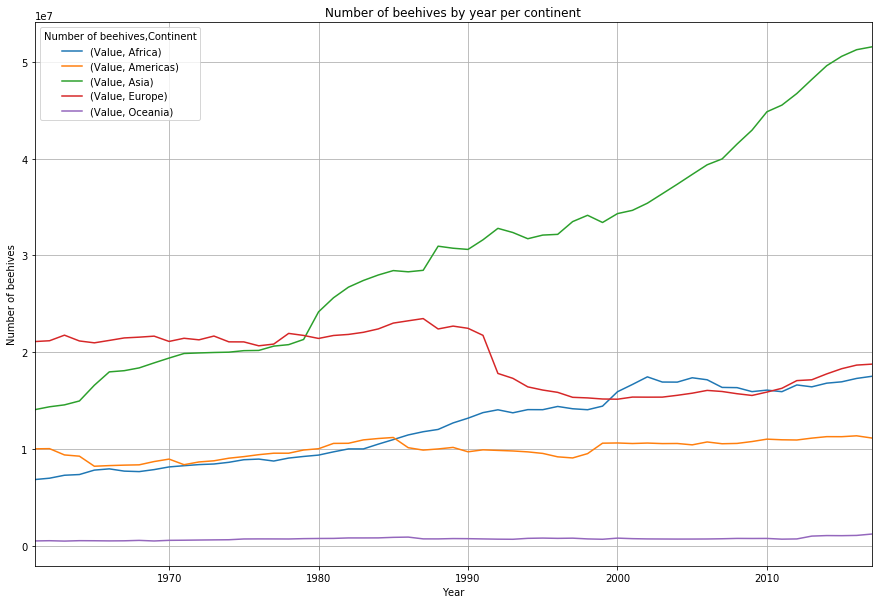

In [8]:
def plot_beehives(df, height=6):
    ax = df.plot(kind='line', figsize=(15,height), grid=True)
    ax.set_ylabel('Number of beehives')
    return ax
    
ax = plot_beehives(beehives, height=10)
ax.set_title('Number of beehives by year per continent');

We can observe the following:

- Asia sees the biggest growth on Earth, surpassing Europe in the 80s, and always growing.
- Europe saw a sharp decline in the beginning of the 90s. It recovers slowly since the 2010s. It still has not reached its former levels of the 80s.
- Afica does not see any real change since the beggining of the 2000s
- Americas seem to not really evolve in numbers since the beginning.
- It's difficult to tell for Oceania, because its production is really low compared to the rest of the world.

Based on this preliminary analysis, we will focus the rest of our analysis on Europe, Asia and Americas.

That's all well and good, but an interesting statistic would be to see the derivate of these values. Let's modify our pivot table.

In [9]:
beehives_derivative = beehives.diff() / beehives
# This obviously creates a NaN value for the first year, let's replace it by 0
beehives_derivative = beehives_derivative.fillna(0)

### Europe

Now, let's compute the values for Europe.

The mean change for the period 1961-2017 is -0.26%.
The standard deviation for the period 1961-2017 is 3.62%


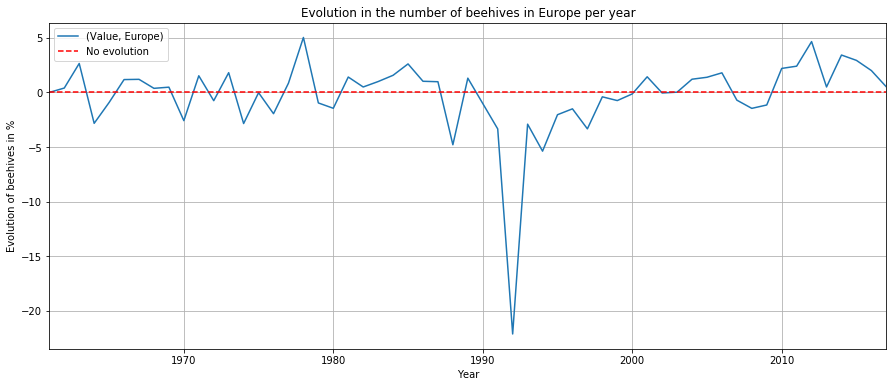

<Figure size 1080x432 with 0 Axes>

In [10]:
beehives_evol_eur = beehives_derivative[('Value','Europe')]
print('The mean change for the period 1961-2017 is %.2f%%.' % (beehives_evol_eur.mean()*100))
print('The standard deviation for the period 1961-2017 is %.2f%%' % (beehives_evol_eur.std()*100))

ax = plot_beehives(beehives_evol_eur*100)
ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Evolution in the number of beehives in Europe per year')
ax.set_ylabel('Evolution of beehives in %')
plt.legend()
plt.figure(figsize=(15,6));

In [11]:
decrease = abs(beehives_evol_eur.min()*100)
msg = 'Europe saw their worst year in total beehives numbers in %d, where it lost %.1f%% of their count.'
print(msg % (beehives_evol_eur.idxmin(), decrease))

Europe saw their worst year in total beehives numbers in 1992, where it lost 22.1% of their count.


Let's note that the mean gain is negative, meaning that Europe saw more losses on a year-to-year basis than gains. Since the standard deviation is quite big, we can however not conclude anything. However, we have seen that the numbers have overall dropped since the 80s, and never recovered.

We can see a very sharp and significant decline in 1992 (-22.1%). Let's investigate on where it came from, by looking at the individual countries in Europe.

In [12]:
def build_continent(continent):
    continent = beehives_raw[beehives_raw['Continent'] == continent]
    continent = continent.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
    continent.columns.names = ['Number of beehives', 'Country']
    return continent
    

beehives_eur = build_continent('Europe')

beehives_eur_gains = beehives_eur.diff()
beehives_eur_gains = beehives_eur_gains.fillna(0)

beehives_eur_1992 = beehives_eur_gains.loc[1992]
beehives_eur_1992[beehives_eur_1992 < 0.0].sort_values()

Number of beehives  Country       
Value               Bulgaria         -101191.0
                    Czechoslovakia    -97966.0
                    Germany           -47000.0
                    Albania           -36700.0
                    France            -16478.0
                    Sweden            -13000.0
Name: 1992, dtype: float64

We see that there are 6 countries that lost beehives in 1992. Let's investigate them individually.

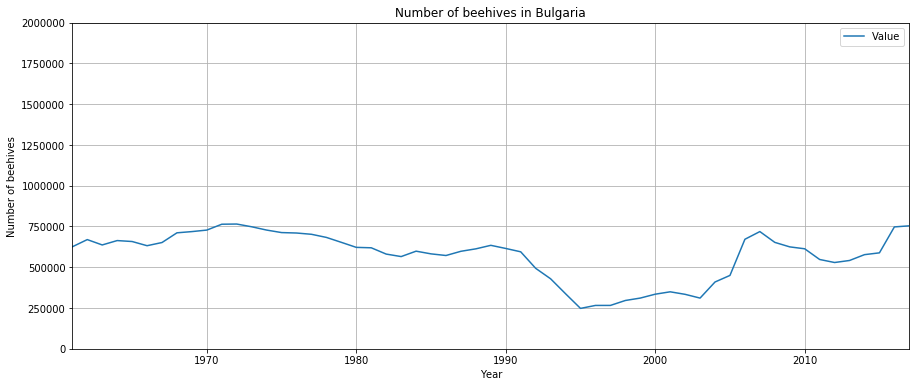

In [13]:
def plot_country(country, top=2e6):
    ax = plot_beehives(beehives_raw[beehives_raw['Area'] == country].set_index('Year'))
    ax.set_title('Number of beehives in %s' % country)
    ax.set_ylim(bottom=0, top=top)
    
plot_country('Bulgaria')

We see that the number of beehives in Bulgaria dropped significantly during the first years of the 90s, and rose again in the mid 00s. It is currently at its highest levels, observed during the 70s. This is certainly due to the fall of the USSR and the Warsaw Pact, which dramatically changed the economic incentives for the Bulgarian population and bee keepers. So this is a legitimate loss for this year.

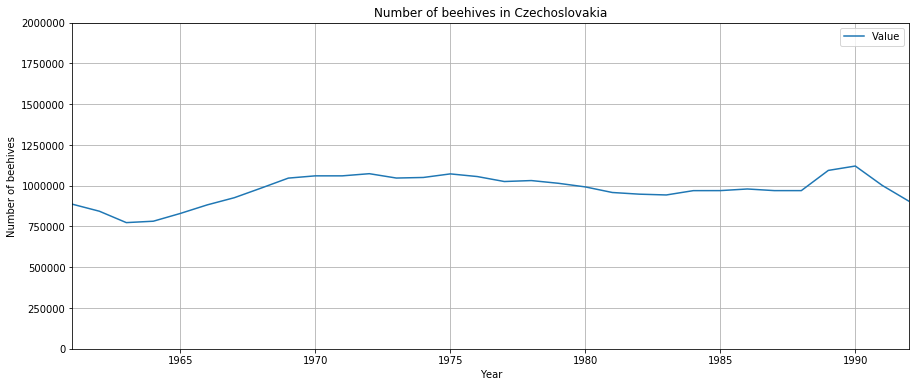

In [14]:
plot_country('Czechoslovakia')

The reason we have no data after 1992 is that the country was split and became Czechia and Slovakia. Let's build the graph as if the country never split.

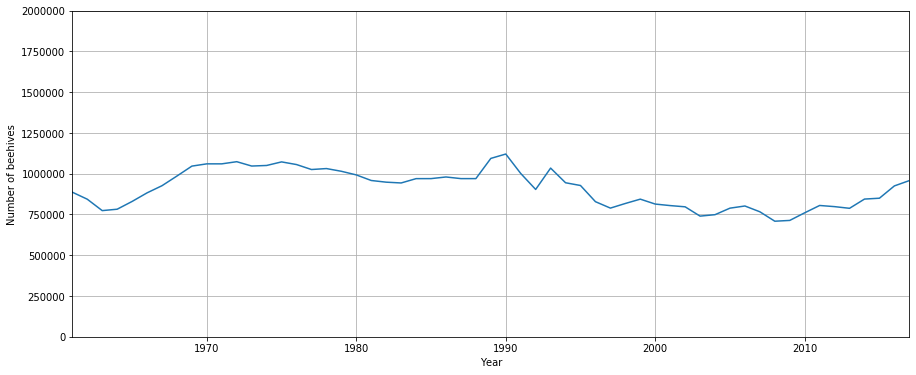

In [15]:
def extract_value(country, year):
    return beehives_raw[beehives_raw['Area'] == country].set_index('Year').loc[year].values[1]

beehives_cshh = beehives_raw[beehives_raw['Area'].isin(['Czechia', 'Slovakia'])]
beehives_cshh = beehives_cshh.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
beehives_cshh.columns.names = ['Number of beehives', 'Country']
beehives_cshh[('Value', 'Czechoslovakia')] = beehives_cshh[('Value', 'Czechia')] + beehives_cshh[('Value', 'Slovakia')]
beehives_cshh = beehives_raw[beehives_raw['Area'] == 'Czechoslovakia'].set_index('Year')['Value'].append(beehives_cshh[('Value', 'Czechoslovakia')])
ax = beehives_cshh.plot(kind='line',figsize=(15,6),grid=True)
ax.set_ylabel('Number of beehives')
ax.set_ylim(bottom=0, top=2e6);

With this now complete statistic for "Czechoslovakia", we see a gloally very similar outcome than what Bulgaria experienced. But the country (-ies) did not manage to come back to their levels of before the fall of communism in Europe, even though the drop was far less impressive than for Bulgaria.

Let's analyse the next in the list, namely Germany.

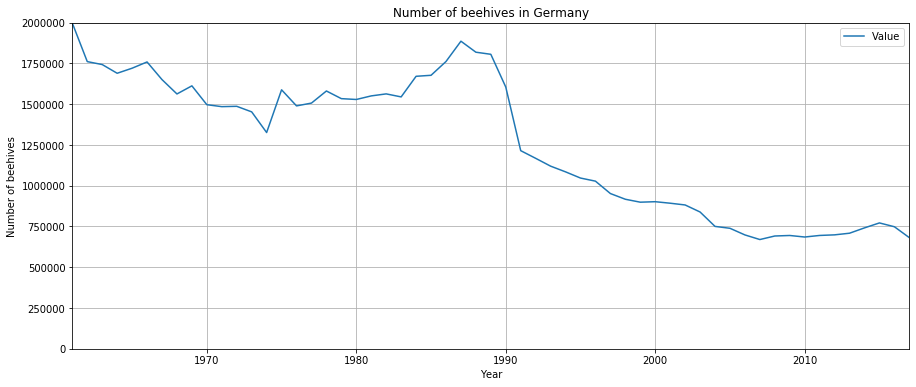

In [16]:
plot_country('Germany')

We also see a significant drop from the beginning of the 90s. Contrary to other countries previously encountered, Germany never came close to its glorious past days. We see an almost continuous decline since the end of the 80s, finally stablizing in the mid 00s. We can only suppose that bee keeping was a big factor in Eastern Germany, and since the reunification, it isn't seen as lucrative in this region Bee keepers must have simply shifted focus.

We also note that Germany was a very big "producer" of beehives in 1961, when the statistics began. This is not the case now. The numbers fell from 2 millions to ca. 700'000 (-65%).

Now, let's see Albania.

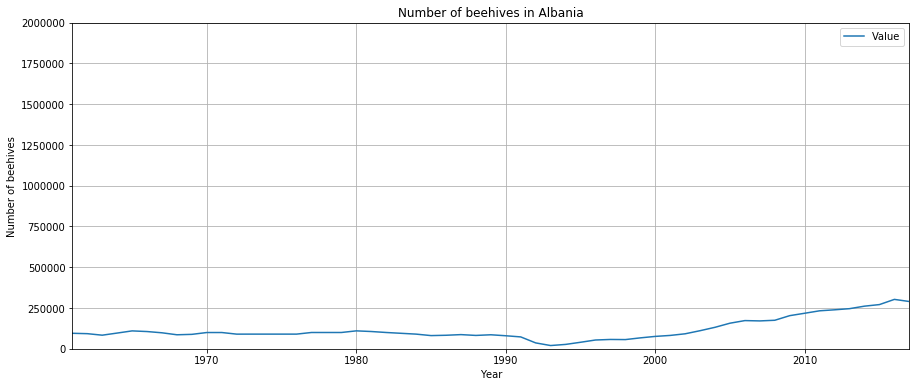

In [17]:
plot_country('Albania')

The wars in the Balkans was probably the cause of this drop. However, after this, the number of beehives grew, whereas it was only stable before these terrible events. It now has much more beehives than during the cold war.

Let's now see France.

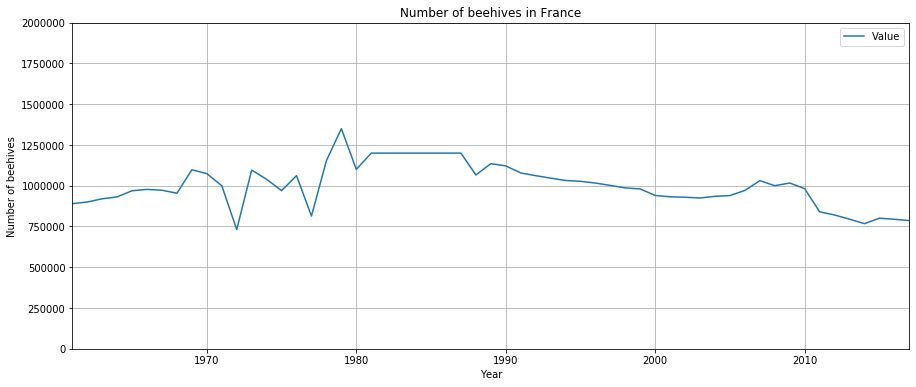

In [18]:
plot_country('France')

It looks like no updated number of beehives were given in the 80s, so the latest value was simply reported for all these years. After the 80s, we see a continuous drop in their numbers, until today, which is one of the lowest recorded numbers for France.

We can see some "glitches" in the 70s, probably due to counting - surveying - errors. It's unlikely the numbers would have changed so quickly.

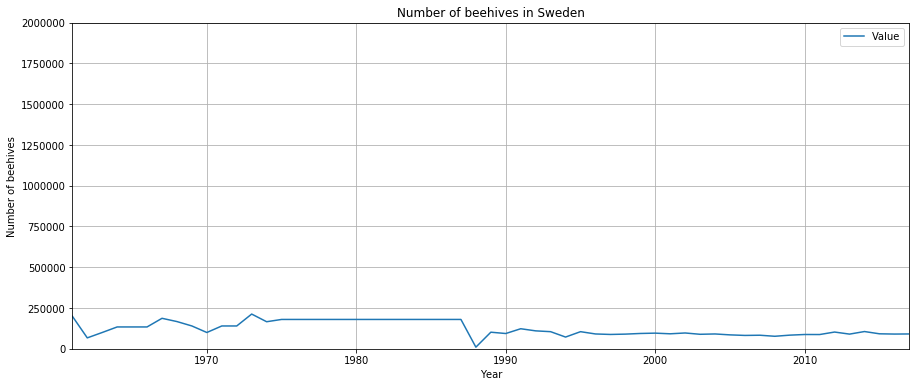

In [19]:
plot_country('Sweden')

The last country on our list, Sweden, sees their number be very stable since the 90s.

Now, let's analyze the recent gains observed in Europe.

In [20]:
beehives_eur_2010s = beehives_eur_gains.loc[beehives_eur_gains.index >= 2010]
beehives_gains_2010s = beehives_eur_2010s.max().sort_values(ascending=False)
beehives_gains_2010s = beehives_gains_2010s[beehives_gains_2010s > 2e5]
beehives_gains_2010s

Number of beehives  Country           
Value               Serbia                358954.0
                    Romania               217731.0
                    Russian Federation    200772.0
dtype: float64

We note that a few countries have known some exceptional years of growth. Let's analyze Serbia, Romania and Russia.

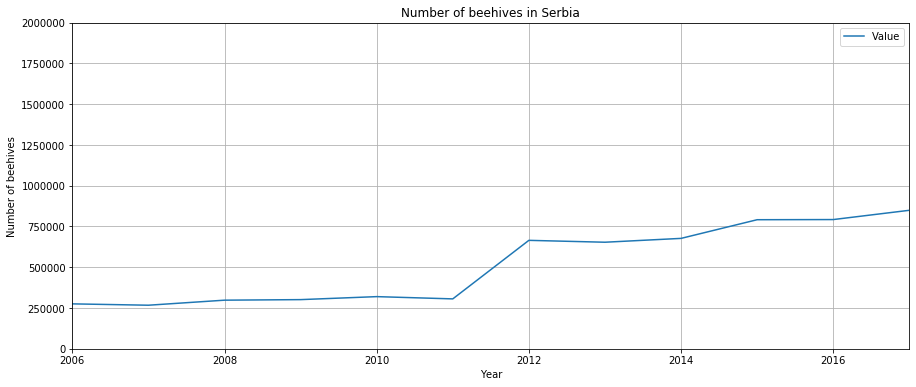

In [21]:
plot_country('Serbia')

Again, Serbia is a fairly new country, since before it was Serbia and Montenegro, and even before Yugoslavia. But this suffices to see that the grwoth observed in the 2010s is very impressive indeed, from ca. 250'000 to 800'000.

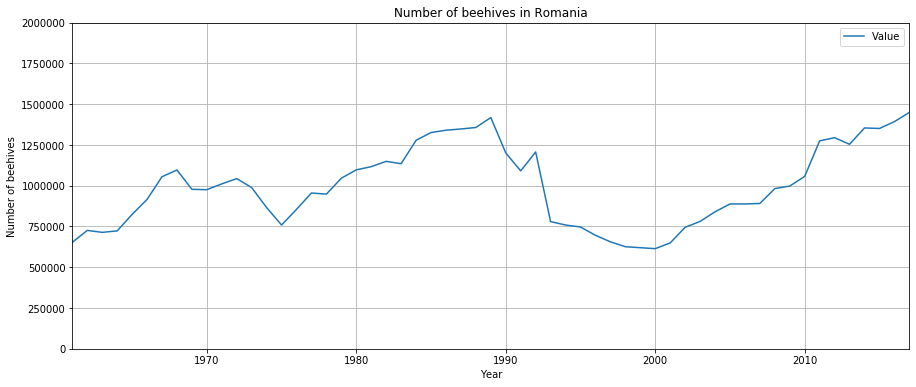

In [22]:
plot_country('Romania')

Here, we have almost a carbon copy of the behavior observed in Bulgaria. Romania just regained the levels at which they were before the fall of the Eastern Bloc.

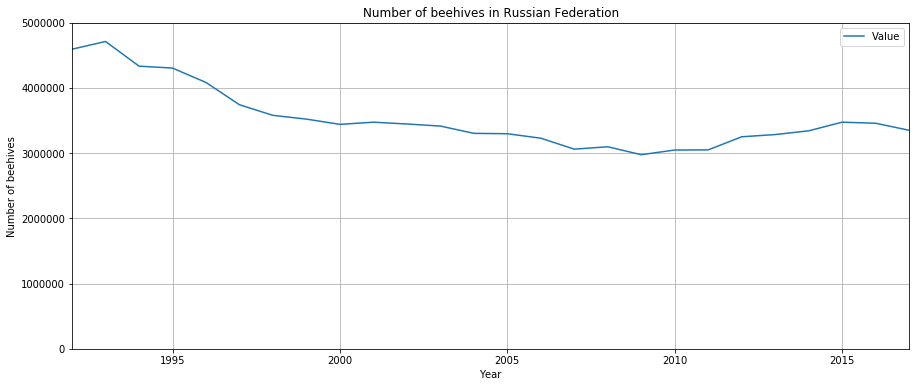

In [23]:
ax = plot_country('Russian Federation', top=5e6)

We see that Russia has an enormous number of beehives. There is a significant drop since the fall of the USSR, which seems nowadays more or less stabilized.

Let's finally see which European countries have the most beehives.

In [24]:
beehives_eur[beehives_eur.index == 2017].iloc[0].sort_values(ascending=False).head(10)

Number of beehives  Country           
Value               Russian Federation    3349976.0
                    Spain                 2904971.0
                    Poland                1589276.0
                    Greece                1561498.0
                    Romania               1449318.0
                    Serbia                 849280.0
                    Hungary                816000.0
                    France                 786172.0
                    Bulgaria               754105.0
                    Germany                681682.0
Name: 2017, dtype: float64

As we observed just before, Russia has the biggest number of behives, followed closely by Spain. Then, we have a group composed of Poland, Greece and Romania. We have then analyzed the rest of the countries.

We can conclude this portion of the analysis that the significant drop observed in Europe in the beginning of the 90s was certainly due to the fall of the USSR and the whole Eastern Bloc, and all the economic turmoil it caused.

### Asia

Firstly, let's see the biggest players in Asia.

In [25]:
beehives_asia = build_continent('Asia')
beehives_asia[beehives_asia.index == 2017].iloc[0].sort_values(ascending=False).head(10)

Number of beehives  Country                   
Value               India                         12763684.0
                    China                          9156882.0
                    China, mainland                9031457.0
                    Turkey                         7796666.0
                    Iran (Islamic Republic of)     7271825.0
                    Republic of Korea              1724389.0
                    Syrian Arab Republic            520795.0
                    Uzbekistan                      488200.0
                    Pakistan                        400019.0
                    Viet Nam                        278448.0
Name: 2017, dtype: float64

We see several outliers: India, China (which is both "China, mainland" and "China, Taiwan Province of"), Turkey and Iran. Let's see their respective evolutions.

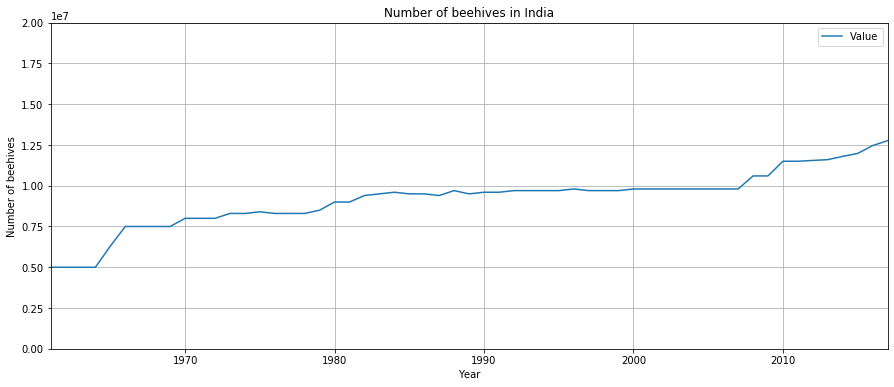

In [26]:
plot_country('India', top=2e7)

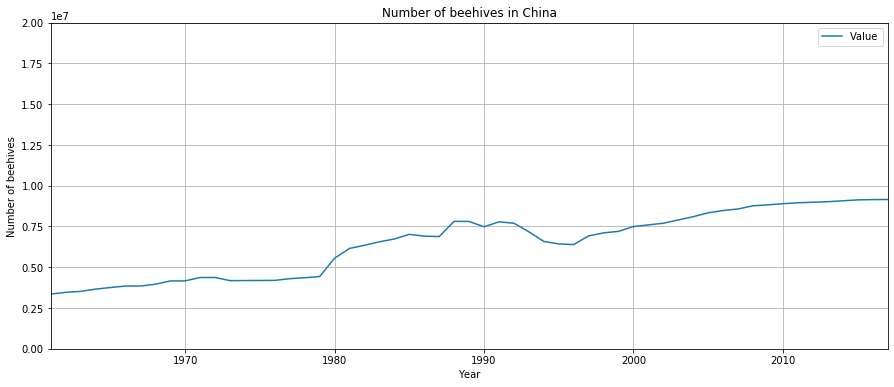

In [27]:
plot_country('China', top=2e7)

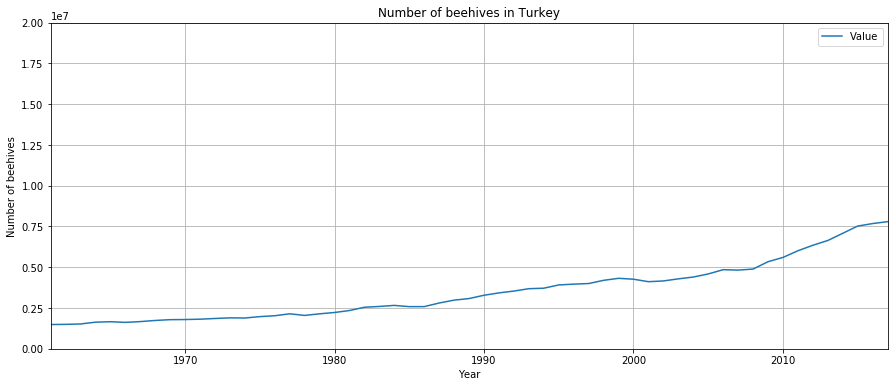

In [28]:
plot_country('Turkey', top=2e7)

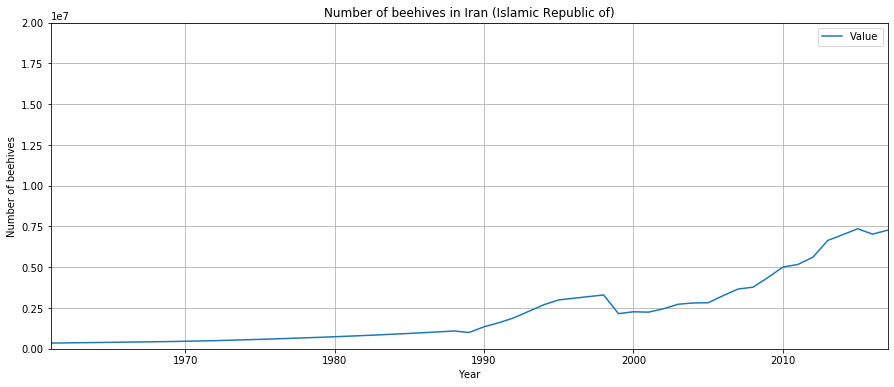

In [29]:
plot_country('Iran (Islamic Republic of)', top=2e7)

The beehive growth in these countries is mainly due to their economic growth, even if we are not sure why Turkey gained such an interest in beehives in the recent years. The global Asian growth can be reduced to the growth of these countries, since their numbers are far beyond any other country in Asia.

### Americas

Since the beehive numbers are stable in America, let's plot the biggest producers' history.

In [30]:
beehives_am = build_continent('Americas')
beehives_am[beehives_am.index == 2017].iloc[0].sort_values(ascending=False).head()

Number of beehives  Country                 
Value               Argentina                   3003036.0
                    United States of America    2669000.0
                    Mexico                      1853807.0
                    Brazil                      1012692.0
                    Canada                       692231.0
Name: 2017, dtype: float64

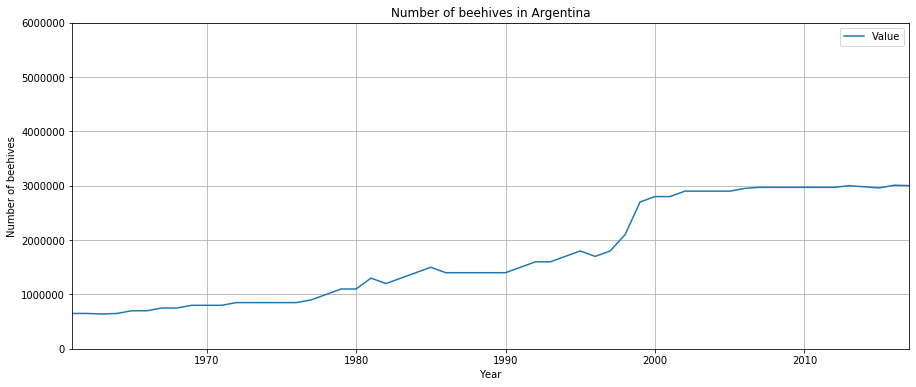

In [31]:
plot_country('Argentina', top=6e6)

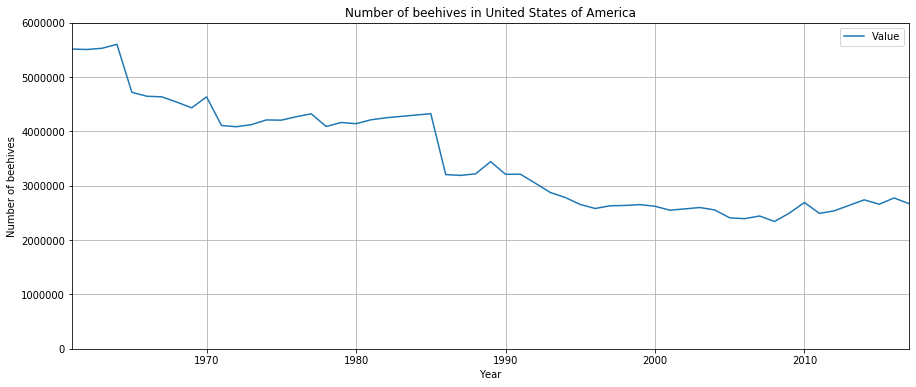

In [32]:
plot_country('United States of America', top=6e6)

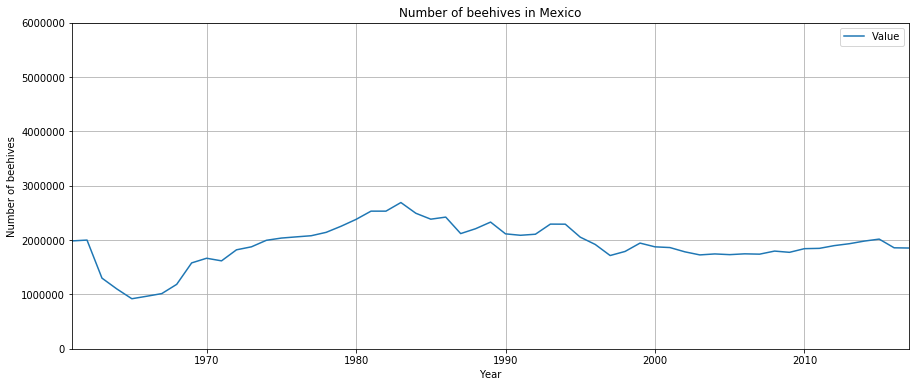

In [33]:
plot_country('Mexico', top=6e6)

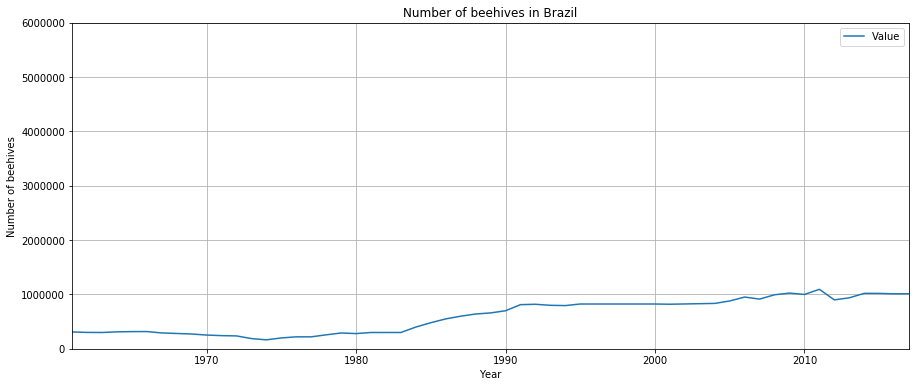

In [34]:
plot_country('Brazil', top=6e6)

We see 4 very different behaviors:
    
- Argentina has the most beehives in the Americas. Their numbers grew at first very quickly, but are stable since ca. 2000. We will come back to this in part 3.
- The US are second, but had way more beehives in the 60s. Their numbers fell until the mid 90s (they more than halved in this time period!), then stabilized.
- Mexico is overall stable for the period (1961-2017)
- Brazil saw a very big increase in the number of beehives in the 80s, and then stablized their numbers.

In conclusion, we mostly explained the big shifts in numbers of beehives using socio-economic arguments. However, we cannot say that some of these changes were not due to pests. This will be the main focus of the latter points (4-5).

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Let's apply the same process to the honey production data than to the number of beehives, but here for both Europe and the US.

In [35]:
honey_raw = pd.read_csv('data/FAOSTAT_Livestock_Primary.csv')
honey_raw = honey_raw[['Area', 'Year', 'Value']]
honey_raw['Continent'] = honey_raw.apply(lambda row: countries.loc[row['Area']], axis=1)
honey_raw.head()

Area  Year   Value Continent
0  Afghanistan  1961  2000.0      Asia
1  Afghanistan  1962  2000.0      Asia
2  Afghanistan  1963  2000.0      Asia
3  Afghanistan  1964  2000.0      Asia
4  Afghanistan  1965  3000.0      Asia

In [36]:
honey_eur = honey_raw[honey_raw['Continent'] == 'Europe'].drop('Area', 1)
honey_eur = honey_eur.pivot_table(index=['Year'], columns=['Continent'], aggfunc=np.sum)
honey_eur.columns.names = ['Honey production in tonnes', 'Continent']

Let's check if we have the same countries as for the number of beehives.

In [37]:
honey_countries_eur = honey_raw[honey_raw['Continent'] == 'Europe']['Area'].value_counts().keys()
beehives_countries_eur = beehives_raw[beehives_raw['Continent'] == 'Europe']['Area'].value_counts().keys()
print(set(honey_countries_eur).symmetric_difference(set(beehives_countries_eur)))
print(set(honey_countries_eur) - set(beehives_countries_eur))

{'Norway', 'Ireland', 'Denmark'}
{'Denmark', 'Ireland', 'Norway'}


We see that we do not have any beehive numbers for Denmark, Ireland and Norway. Let's see what percentage of the European honey production they make up in 2017.

In [38]:
honey_prod_eur = honey_eur.loc[2017]['Value']['Europe']
honey_prod_2017 = honey_raw[honey_raw['Year'] == 2017]
honey_prod_den = honey_prod_2017[honey_prod_2017['Area'] == 'Denmark']['Value'].values[0]
honey_prod_eir = honey_prod_2017[honey_prod_2017['Area'] == 'Ireland']['Value'].values[0]
honey_prod_nor = honey_prod_2017[honey_prod_2017['Area'] == 'Norway']['Value'].values[0]
proportion = (honey_prod_den + honey_prod_eir + honey_prod_nor) / honey_prod_eur
print('Denmark, Ireland and Norway make up %f%% of the European honey production.' % (proportion * 100))

Denmark, Ireland and Norway make up 0.102713% of the European honey production.


These 3 countries make up less than one thousandth of the total European honey production, so we can safely drop them from the dataset.

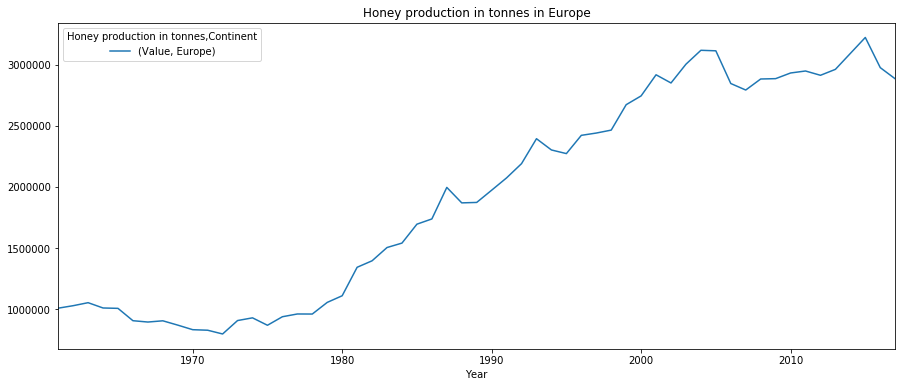

In [39]:
# Redo statistics without Denmark, Ireland and Norway
honey_eur = honey_raw[honey_raw['Continent'] == 'Europe']
honey_eur = honey_eur[honey_eur['Area'].isin(beehives_countries_eur)].drop('Area', 1)
honey_eur = honey_eur.pivot_table(index=['Year'], columns=['Continent'], aggfunc=np.sum)
honey_eur.columns.names = ['Honey production in tonnes', 'Continent']

ax = honey_eur.plot(kind='line',figsize=(15,6))
ax.set_title('Honey production in tonnes in Europe');

Here, we already see a major difference with respects to what we observed with the number of beehives. Honey production did not stop growing in the 90s, even though there was a big drop in the number of beehives.

Let's plot the differences between each year for both honey and beehives.

In [40]:
honey_derivative = honey_eur.diff() / honey_eur
honey_derivative = honey_derivative.fillna(0)[('Value', 'Europe')]

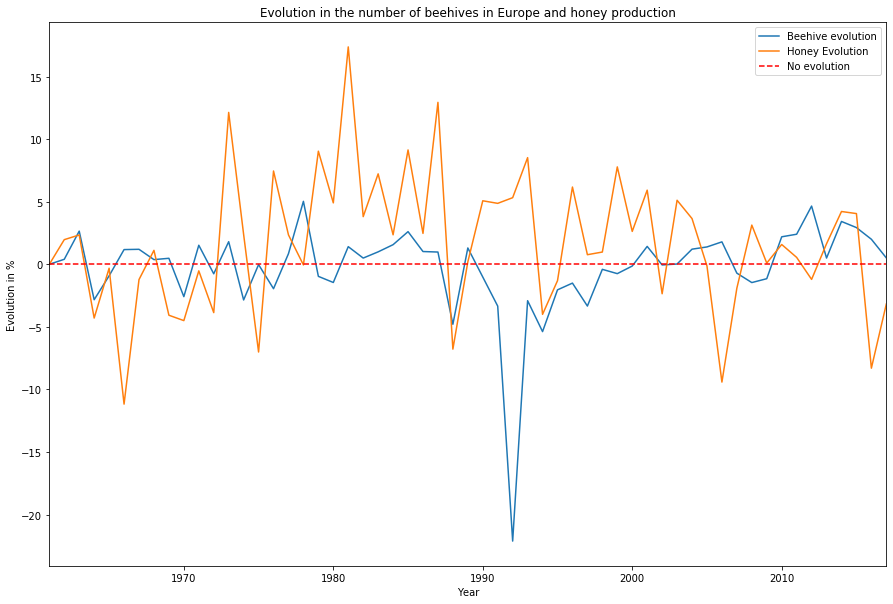

In [41]:
ax = (beehives_evol_eur*100).plot(kind='line', figsize=(15,10), label='Beehive evolution')
(honey_derivative*100).plot(ax=ax, label='Honey Evolution')

ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Evolution in the number of beehives in Europe and honey production')
ax.set_ylabel('Evolution in %')
plt.legend();

The mean of the change per year is 1.94%.
The standard deviation of the change per year is 6.60%.


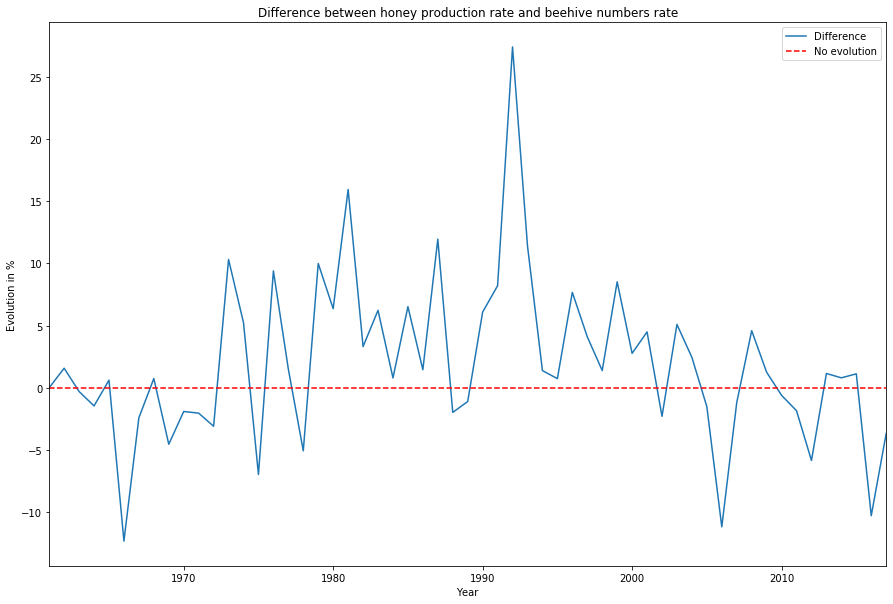

In [42]:
eur_diff = honey_derivative - beehives_evol_eur
ax = (eur_diff*100).plot(kind='line', figsize=(15,10), label='Difference')
ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Difference between honey production rate and beehive numbers rate')
ax.set_ylabel('Evolution in %')
plt.legend();
print('The mean of the change per year is %.2f%%.' % (eur_diff.mean()*100))
print('The standard deviation of the change per year is %.2f%%.' % (eur_diff.std()*100))

On this last series of graphs, we can see that the rate of honey production is very often superior to the one of the number of beehives, even though we cannot conclude anythin using the mean and standard deviation. This can mean that producers are more efficient with lesser numbers of beehives. We will later compute the correlation between these evolution, this is to simply grasp an intuitive understanding of the data.

Let's do the same thing with the US.

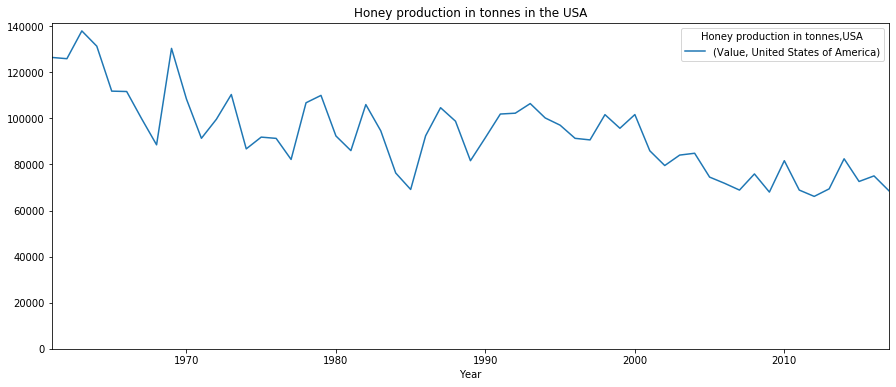

In [43]:
honey_us = honey_raw[honey_raw['Area'] == 'United States of America'].drop('Continent', 1)
honey_us = honey_us.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
honey_us.columns.names = ['Honey production in tonnes', 'USA']
ax = honey_us.plot(kind='line',figsize=(15,6))
plt.ylim(bottom=0)
ax.set_title('Honey production in tonnes in the USA');

Here, on the contrary, we rather confirm that the US have far fewer beehives by looking at the honey production.

In [44]:
honey_us_derivative = honey_us.diff() / honey_us
honey_us_derivative = honey_us_derivative.fillna(0)[('Value', 'United States of America')]

In [45]:
beehives_evol_us = beehives_raw.drop('Continent', 1)
beehives_evol_us = beehives_evol_us[beehives_evol_us['Area'] == 'United States of America']
beehives_evol_us = beehives_evol_us.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
beehives_evol_us.columns.names = ['Number of beehives', 'Country']

beehives_evol_us = beehives_evol_us.diff() / beehives_evol_us
beehives_evol_us = beehives_evol_us.fillna(0)[('Value', 'United States of America')]

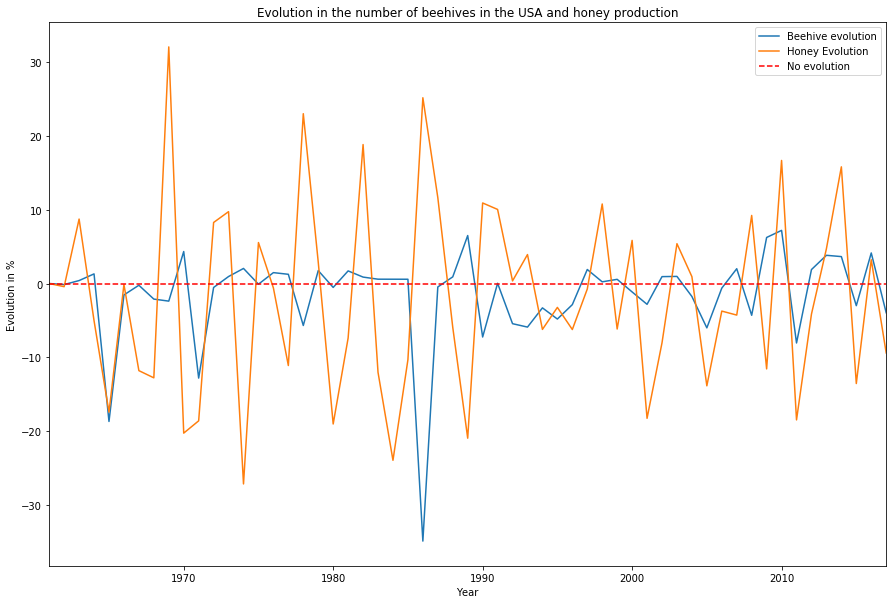

In [46]:
ax = (beehives_evol_us*100).plot(kind='line', figsize=(15,10), label='Beehive evolution')
(honey_us_derivative*100).plot(ax=ax, label='Honey Evolution')

ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Evolution in the number of beehives in the USA and honey production')
ax.set_ylabel('Evolution in %')
plt.legend();

The mean of the change per year is -0.47%.
The standard deviation of the change per year is 15.05%.


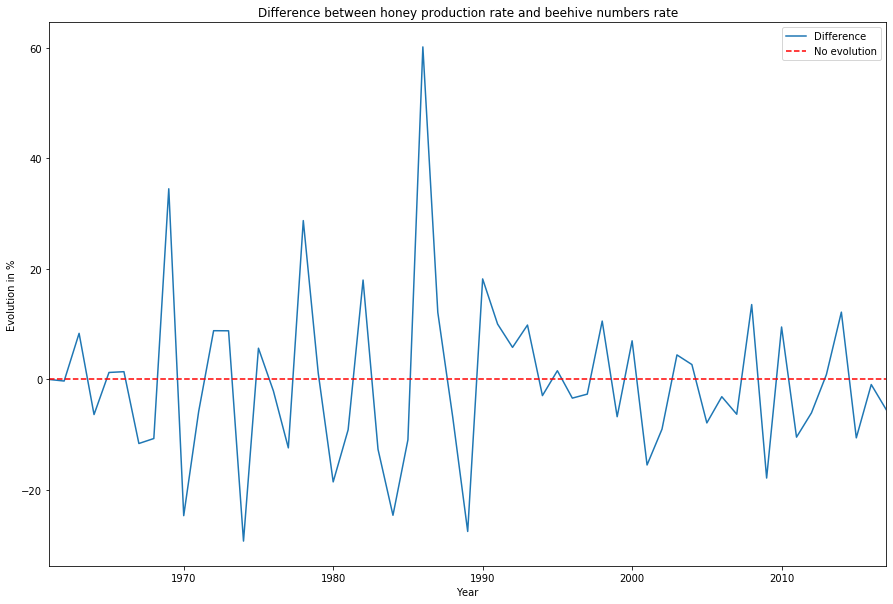

In [47]:
us_diff = honey_us_derivative - beehives_evol_us
ax = (us_diff*100).plot(kind='line', figsize=(15,10), label='Difference')
ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Difference between honey production rate and beehive numbers rate')
ax.set_ylabel('Evolution in %')
plt.legend();
print('The mean of the change per year is %.2f%%.' % (us_diff.mean()*100))
print('The standard deviation of the change per year is %.2f%%.' % (us_diff.std()*100))

Here, contrary to Europe, we even see an overall mean that is negative, meaning that honey production drops (on a year-by-year basis) more than the number of beehives, or that it grows less.

However, we again have a high standard deviation (due to the small number of years we have to work on). So, let's compute the correlation of the values to confirm our intuition.

In [48]:
eu_corr = honey_eur[('Value', 'Europe')].to_frame().corrwith(beehives[('Value', 'Europe')])[('Value', 'Europe')]
print('We observe a correlation of %.3f between honey production and number of beehives in Europe.' % eu_corr)

We observe a correlation of -0.802 between honey production and number of beehives in Europe.


In [49]:
us_corr = honey_us[('Value', 'United States of America')].to_frame().corrwith(beehives_raw[beehives_raw['Area'] == 'United States of America'].set_index('Year')['Value'])[('Value', 'United States of America')]
print('We observe a correlation of %.3f between honey production and number of beehives in the USA.' % us_corr)

We observe a correlation of 0.674 between honey production and number of beehives in the USA.


We see a significant negative correlation between the number of beehives and honey production in Europe, meaning that bee keepers are more and more efficient as time goes on.

And, as seen with our previous graphs, we observe the opposite in the US, where both numbers seem to fall at the same time. We will explain this phenomenon in part 5.

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

For this data analysis, we will plot time series in order to make comparisons. This is the purpose of the two following functions.

In [50]:
#Take one time serie and plot
def plot_time_serie(df, ylabel="", xlabel="", title=""):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df, linestyle='-')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xlim(df.index.min(), df.index.max())
    return ax

In [51]:
#Take multiple time series and plot them together
def plot_time_series(dfs, names, ylabel="", xlabel="", title="", position = 'upper left'):
    fig, ax = plt.subplots(figsize=(15,6))
    if isinstance(dfs, pd.DataFrame): 
        dfs =[dfs[name] for name in names]
    for df, name in zip(dfs, names):
        ax.plot(df, linestyle='-', label=name)
        ax.set_xlim(df.index.min(), df.index.max())
    ax.set_ylabel(ylabel)
    ax.legend(loc=position)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    return ax

We decided to take a look on exchanges of honey and beehives throughout the last decades. We will thus use the FAOSTAT_Trade_Matrix on the `honey` and `beehives` fields and the FAOSTAT_Livestock_Primary dataset in complement for our future analysis.

In [52]:
trade_matrix = pd.read_csv("data/FAOSTAT_Trade_Matrix.csv")
honey_production_raw = pd.read_csv("data/FAOSTAT_Livestock_Primary.csv")

Let's first take a look at the total honey production.

In [53]:
honey_production = honey_production_raw[(honey_production_raw["Item"] == "Honey, natural") & (honey_production_raw["Unit"] == "tonnes")]
honey_production = honey_production[["Area", "Year", "Value"]]
honey_production = honey_production.rename(columns={"Area": "Country", "Value": "Production Value"})

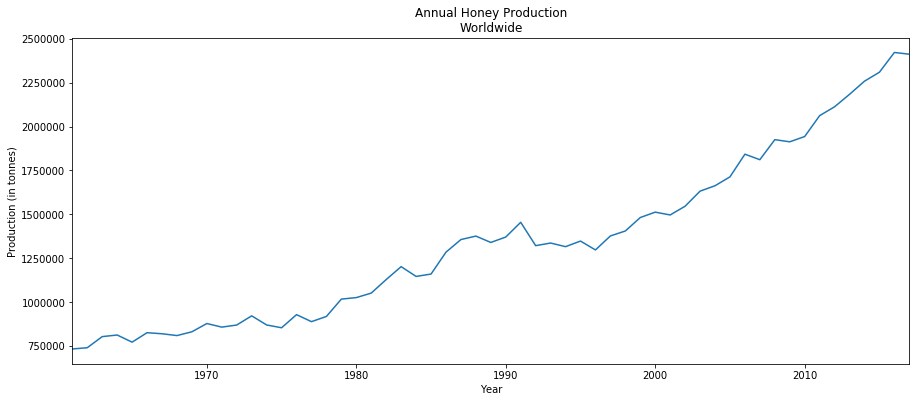

In [54]:
honey_year_production = honey_production.groupby("Year")["Production Value"].sum()
plot_time_serie(honey_year_production, 'Production (in tonnes)', 'Year', 'Annual Honey Production\nWorldwide')

We can observe that the honey production increased almost monotonically since the 60s.

Now let's see the Trade matrix.

In [55]:
def print_corrcoef(exports, imports, name):
    print(f"The correlation between imports and exports of {name} is {exports.corr(imports, method='pearson')}.")

The correlation between imports and exports of beehives (in unit) is -0.07476498880707769.
The correlation between imports and exports of beehives (in 1000 $US) is 0.8813326996733277.


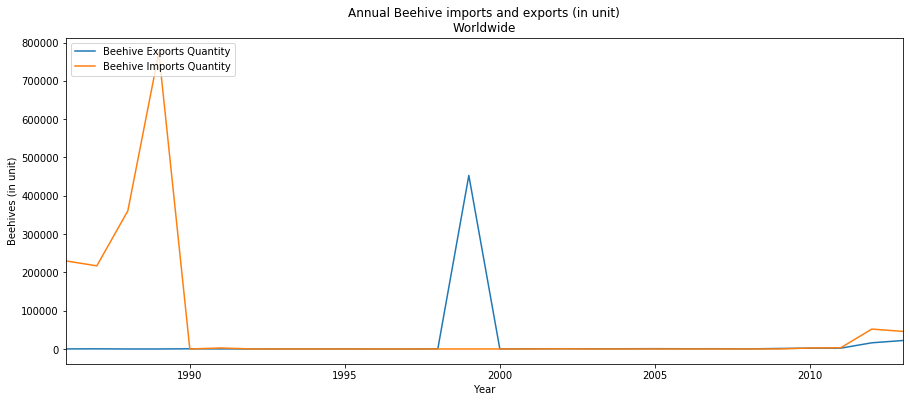

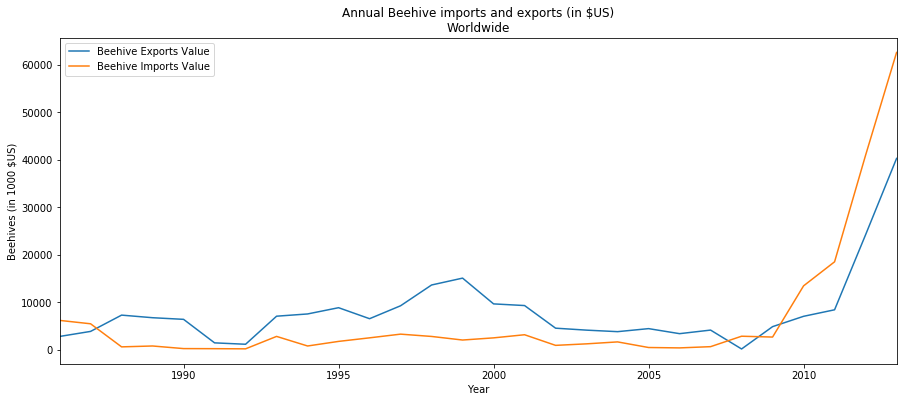

In [56]:
beehives = trade_matrix[(trade_matrix["Item"] == "Beehives")]

beehives_imports = beehives[(beehives["Element"] == "Import Quantity")]
imports = beehives_imports.groupby("Year").sum()["Value"]

beehives_exports = beehives[(beehives["Element"] == "Export Quantity")]
exports = beehives_exports.groupby("Year").sum()["Value"]

plot_time_series([exports, imports ], ['Beehive Exports Quantity', 'Beehive Imports Quantity'], "Beehives (in unit)", "Year", "Annual Beehive imports and exports (in unit)\nWorldwide")
print_corrcoef(exports, imports, "beehives (in unit)")
      
beehives_imports = beehives[(beehives["Element"] == "Import Value")]
imports = beehives_imports.groupby("Year").sum()["Value"]

beehives_exports = beehives[(beehives["Element"] == "Export Value")]
exports = beehives_exports.groupby("Year").sum()["Value"]

plot_time_series([exports, imports ], ['Beehive Exports Value', 'Beehive Imports Value'], "Beehives (in 1000 $US)", "Year", "Annual Beehive imports and exports (in $US)\nWorldwide")
print_corrcoef(exports, imports, "beehives (in 1000 $US)")

In [57]:
Albania_Macedonia_beehives_trades = beehives[(beehives["Reporter Countries"] == 'Albania') & (beehives["Partner Countries"] == 'North Macedonia') & (beehives["Value"] > 0) & (beehives["Year"] == 2009)]
print(f"We have {Albania_Macedonia_beehives_trades.shape[0]} link between Albania and North Macedonia.")
Albania_Macedonia_beehives_trades

We have 1 link between Albania and North Macedonia.


Domain Code                 Domain  Reporter Country Code  \
289          TM  Detailed trade matrix                      3   

    Reporter Countries  Partner Country Code Partner Countries  Element Code  \
289            Albania                   154   North Macedonia          5622   

          Element  Item Code      Item  Year Code  Year      Unit  Value Flag  \
289  Import Value       1181  Beehives       2009  2009  1000 US$      2  NaN   

    Flag Description  
289    Official data

We should expect the same value of imported and exported beehives per year, which is not the case here (see figures above). We would expect symmetrical behaviour (export from A to B <=> import from B to A), which is not the case in the example above. The correlation coefficient is not high enough to use them. Thus, `beehives` exports and imports can not be used here.

In [58]:
honey = trade_matrix[trade_matrix["Item"] == "Honey, natural"]

honey_imports = honey[honey["Element"] == "Import Quantity"]
honey_imports = honey_imports[["Reporter Countries", "Year", "Value"]]
honey_imports = honey_imports.rename(columns={"Reporter Countries": "Country", "Value": "Import Value"})

honey_exports = honey[honey["Element"] == "Export Quantity"]
honey_exports = honey_exports[["Reporter Countries", "Year", "Value", "Partner Countries"]]
honey_exports = honey_exports.rename(columns={"Reporter Countries": "Country", "Value": "Export Value"})

We will now see if the honey imports and exports are more usable.

The correlation between imports and exports of honey is 0.9900288530138095.


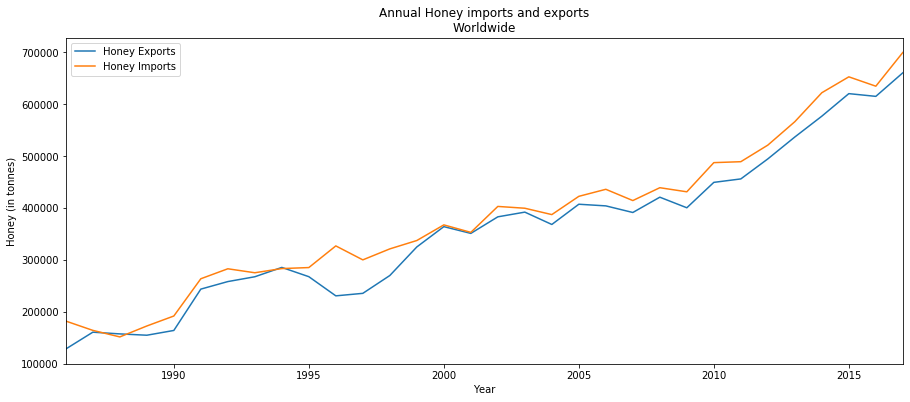

In [59]:
exports = honey_exports.groupby(["Year"]).sum()["Export Value"]
imports = honey_imports.groupby(["Year"]).sum()["Import Value"]

plot_time_series([exports, imports ], ['Honey Exports', 'Honey Imports'], "Honey (in tonnes)", "Year", "Annual Honey imports and exports\nWorldwide")
print_corrcoef(exports, imports, "honey")

We can see that the two curves are very similar. We will focus our analysis on the honey exports and imports since the data seems more usable.

In [60]:
exports_country = honey_exports.groupby(["Year", "Country"]).agg('sum')
imports_country = honey_imports.groupby(["Year", "Country"]).agg('sum')

In [61]:
exports_country.head()

Export Value
Year Country                         
1986 Argentina                  18601
     Australia                   9536
     Austria                       82
     Belgium-Luxembourg          1553
     Belize                       249

We will go deeper in the dataset and try to see how the honey is distributed between exports and imports over the world.

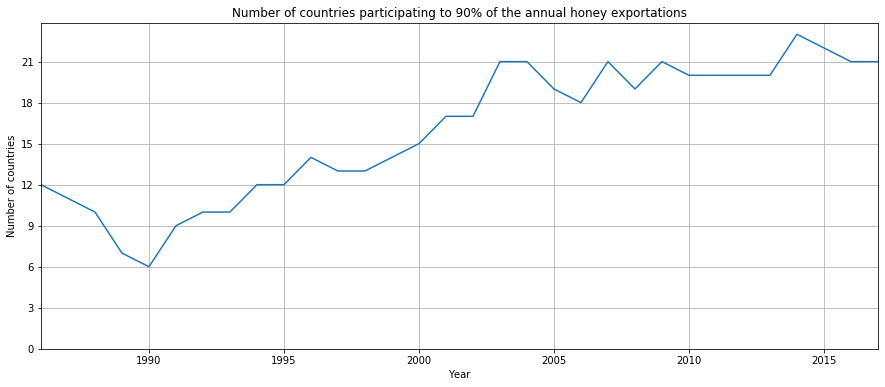

In [62]:
top_exporters = exports_country.copy()
top_exporters.reset_index(inplace=True) 
top_exporters['ratio'] = top_exporters["Export Value"] / top_exporters['Export Value'].groupby(top_exporters['Year']).transform('sum')
top_exporters = top_exporters.sort_values("ratio", ascending = False)
top_exporters["cumulative sum"] = top_exporters["ratio"].groupby(top_exporters['Year']).transform('cumsum')

top_exporters = top_exporters[top_exporters["cumulative sum"]<0.9]
best_exporters = top_exporters.groupby("Year")["Country"]
ax = plot_time_serie(best_exporters.count(), ylabel="Number of countries", xlabel="Year", title="Number of countries participating to 90% of the annual honey exportations")
ax.set_yticks(range(0,24,3))
plt.grid()

We can observe that the number of big honey exporters increased last years. This can show a good health of the honey market, let's see the import data to improve our analysis.

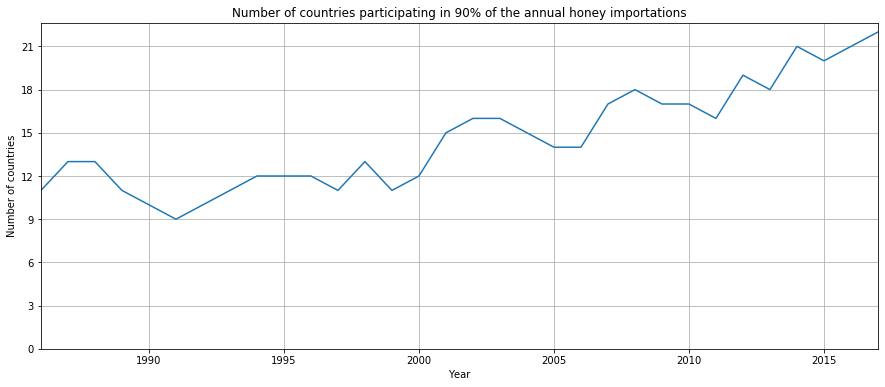

In [63]:
top_importers = imports_country.copy()
top_importers.reset_index(inplace=True) 
top_importers['ratio'] = top_importers["Import Value"] / top_importers['Import Value'].groupby(top_importers['Year']).transform('sum')
top_importers = top_importers.sort_values("ratio", ascending = False)
top_importers["cumulative sum"] = top_importers["ratio"].groupby(top_importers['Year']).transform('cumsum')

top_importers = top_importers[top_importers["cumulative sum"]<0.9]
best_importers = top_importers.groupby("Year")["Country"]
ax = plot_time_serie(best_importers.count(), ylabel="Number of countries", xlabel="Year", title="Number of countries participating in 90% of the annual honey importations")
ax.set_yticks(range(0,24,3))
plt.grid()

We can notice that the number of important importers increased. These countries may not produce enough honey for their consumption anymore. We will try to identify them in the following analysis.

We will try to observe honey exchanges trends for some countries. For that we pick import and export values of each country. We also compute a new value for our analysis called the **Honey Consumption**. It represents the quantity of honey which a country consumes per year and is computed as follows (for one year):

$$ \textrm{Honey Consumption} = \textrm{Honey Production} - \textrm{Honey Exports} + \textrm{Honey Imports} $$

In [64]:
exchanges = pd.merge(honey_production, exports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges = pd.merge(exchanges, imports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges["Honey Consumption"] = exchanges["Production Value"] - exchanges["Export Value"] + exchanges["Import Value"]
exchanges["Balance"] = exchanges["Export Value"] - exchanges["Import Value"]
exchanges = exchanges.set_index('Year')

In [65]:
names = ["Production Value", "Export Value", "Import Value", "Honey Consumption"]
def plot_countries_exchanges(exchanges, countries, position = "upper left"):
    for country in countries:
        country_honey = exchanges[exchanges["Country"] == country]
        plot_time_series(country_honey, names,'Honey (in tonnes)', 'Year', f'Annual Honey Exchanges in {country}', position = position)

#### Multiple kinds of country for exchanges

In [66]:
year = 2017
exchanges_tmp = exchanges.copy()
exchanges_tmp = exchanges_tmp.reset_index()
exchanges_tmp = exchanges_tmp[exchanges_tmp["Year"] == year]

We can see below the countries with the greatest exports in 2017

In [67]:
exports_country.loc[year].sort_values(by = "Export Value", ascending = False).head(5)

Export Value
Country                      
China, mainland        129261
Argentina               70322
Ukraine                 67905
India                   52979
Mexico                  27723

And the countries with the greatest imports in 2017

In [68]:
imports_country.loc[year].sort_values(by = "Import Value", ascending = False).head(5)

Import Value
Country                               
United States of America        202565
Germany                          93069
United Kingdom                   44983
Japan                            42823
France                           35546

#### 1) Countries which consume a lot but do not produce (production is far from enough)

See Japan below

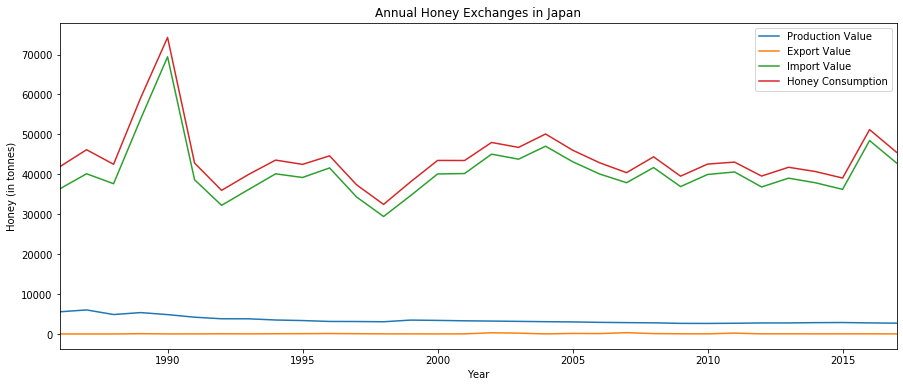

In [69]:
big_importer_country = ["Japan"]
plot_countries_exchanges(exchanges, big_importer_country, position = "upper right")

#### 2) Countries which consume a lot, produce a lot and import a lot.

United States of America, France

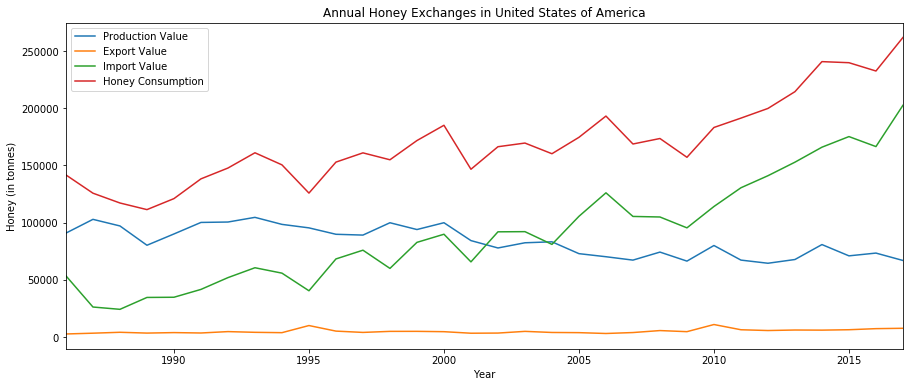

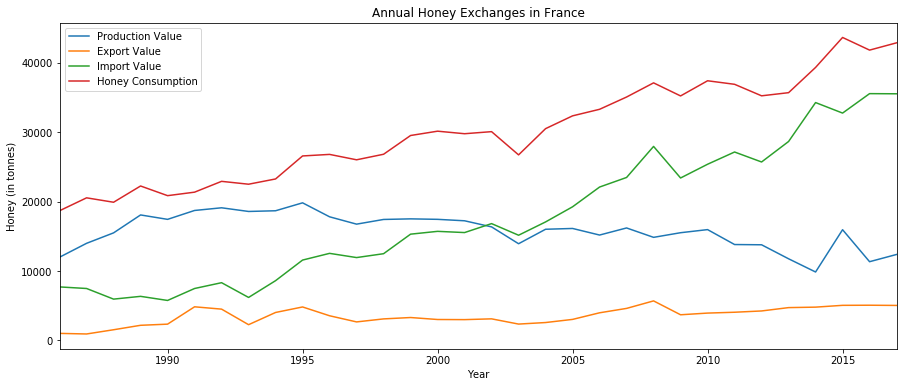

In [70]:
producer_importer_countries = ["United States of America", "France"]
plot_countries_exchanges(exchanges, producer_importer_countries)

We can see that these countries suffer from a poor production. Indeed production appears to have declined in favour of importations. These countries are not self-sufficient anymore and are very dependent on other countries (`importations` > `production`). The USA are the biggest importer.

In [71]:
print("The biggest importer of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Import Value'].idxmax()]["Country"]))

The biggest importer of 2017 is United States of America


#### 3) Countries that consume a lot and produce a lot

China is the biggest honey consumer. It is totaly self-sufficient. It is also the biggest producer and thus can export a lot (it is also the biggest exporter).

In [72]:
print("The biggest exporter of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Export Value'].idxmax()]["Country"]))
print("The biggest producer of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Production Value'].idxmax()]['Country']))
print("The biggest consumer of {} is {}".format(year, exchanges_tmp.loc[exchanges_tmp['Honey Consumption'].idxmax()]["Country"]))

The biggest exporter of 2017 is China, mainland
The biggest producer of 2017 is China, mainland
The biggest consumer of 2017 is China, mainland


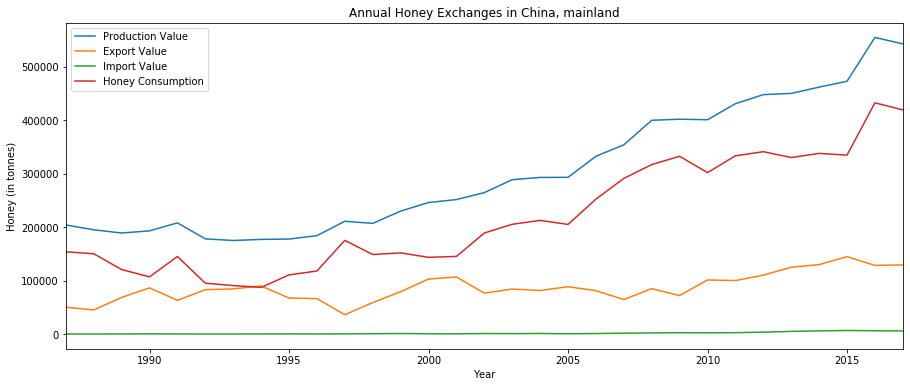

In [73]:
importer_countries = ["China, mainland"]
plot_countries_exchanges(exchanges, importer_countries)

#### 4) Countries which only export

Argentina is a country which is always in the best exporters, however it doesn't consume a lot of it.

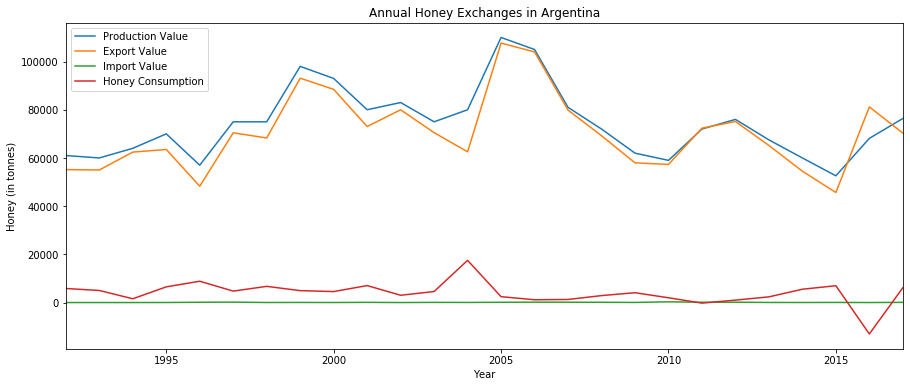

In [74]:
importer_countries = ["Argentina"]
plot_countries_exchanges(exchanges, importer_countries)

It is important to keep in mind that the consumption is a computed value. Hence, if a country stores honey and exports it, then we can end up with a "negative" honey consumption 

#### 5) Countries which became exporters

India and Ukraine

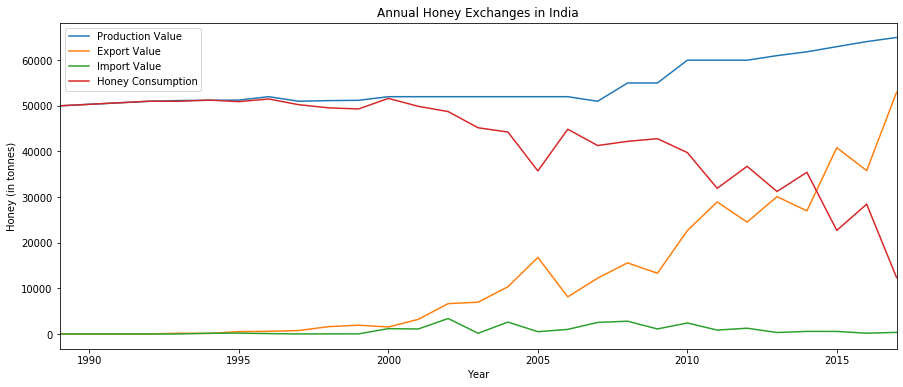

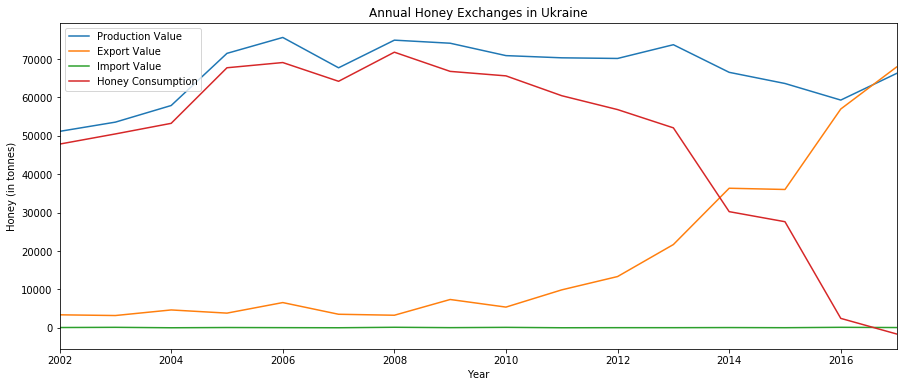

In [75]:
plot_countries_exchanges(exchanges, ["India", "Ukraine"])

We can observe that India, until 2000, was self-sufficient and didn't export honey (same for Ukraine until 2012). From this point we can see a trend inversion. Indeed the country opened the market to exportations. From that point on, we can observe that it became more interesting for India (and Ukraine) to export honey than keeping it in their market.

##### Conclusion

We can observe 3 different kind of countries:
- The countries which **export** the greater part of their honey production (Argentina)
- The countries which **import** the greater part of their honey (France, USA, Japan)
- The countries which **use** the greater part of their honey (China)

We observe that the world is split between honey producers and consumers. Western countries seem to have had production issues in the last decades while other countries became big exporters.

#### Matrix Exploration

We now want to explore the entire trade matrix through years. We first decided to do so with folium. However we prefered to use leaflet (javascript) to have more interactivity - it will be nice for our data story ;).
The goal of this visualisation is to see the trade connections between countries through time.

In [76]:
#transform a dict into a javascript file compatible with our visualisation
def json_to_js(json_, name):
    f = open(f"exportations_graph/main/data/{name}.js", "w+")
    f.write(f"var {name} = ")
    f.write(str(json_))
    f.write(";")
    f.close()

In [77]:
honey_exports

Country  Year  Export Value     Partner Countries
30      Afghanistan  2016             0              Pakistan
52      Afghanistan  2014             1  United Arab Emirates
53      Afghanistan  2016             1  United Arab Emirates
76          Albania  1996             3               Austria
124         Albania  2017             1       China, mainland
...             ...   ...           ...                   ...
171129     Zimbabwe  2002             0                Malawi
171134     Zimbabwe  2015             0              Malaysia
171136     Zimbabwe  2015             0            Mozambique
171214     Zimbabwe  2000             1      Unspecified Area
171238     Zimbabwe  1993             2                Zambia

[42432 rows x 4 columns]

In [78]:
honey_exports = honey_exports[~(honey_exports == 0).any(axis=1)]

For the moment we will select a year. In the future we will have all years in the visualisation.

In [79]:
years = [1995,2005,2017]

In [80]:
def create_dict(t, ie):
    d = {}
    for y in years:
        d[ie +str(y)] = 0
    for year, val in t:
        d[ie +str(year)] = val
    return d

In [81]:
value_per_country = honey_exports[honey_exports["Year"].isin(years)]
value_per_country = value_per_country[["Country", "Export Value", "Year"]].groupby(["Country", "Year"]).agg('sum')

value_per_country = value_per_country.reset_index(level=[1])
value_per_country = value_per_country.T.apply(tuple).groupby("Country").apply(list)
value_per_country = value_per_country.apply(lambda x : create_dict(x, "e")).to_dict()

In [82]:
importations = honey_exports[["Partner Countries", "Export Value", "Year"]].groupby(["Partner Countries", "Year"]).agg('sum')
importations = importations.reset_index(level=[1])
importations = importations.T.apply(tuple).groupby("Partner Countries").apply(list)
importations = importations.apply(lambda x : create_dict(x, "i")).to_dict()

{'Afghanistan': {'i1995': 0,
  'i2005': 66,
  'i2017': 87,
  'i1986': 2,
  'i1988': 1,
  'i1996': 1,
  'i1999': 3,
  'i2001': 2,
  'i2002': 4,
  'i2003': 7,
  'i2004': 22,
  'i2006': 26,
  'i2007': 20,
  'i2008': 22,
  'i2009': 22,
  'i2010': 769,
  'i2011': 58,
  'i2012': 52,
  'i2013': 76,
  'i2014': 231,
  'i2015': 91,
  'i2016': 196},
 'Albania': {'i1995': 1,
  'i2005': 87,
  'i2017': 24,
  'i1992': 2,
  'i1998': 1,
  'i1999': 13,
  'i2000': 103,
  'i2001': 23,
  'i2002': 15,
  'i2003': 12,
  'i2004': 20,
  'i2006': 10,
  'i2007': 8,
  'i2008': 67,
  'i2009': 20,
  'i2010': 16,
  'i2011': 12,
  'i2012': 21,
  'i2013': 16,
  'i2014': 27,
  'i2015': 28,
  'i2016': 23},
 'Algeria': {'i1995': 1630,
  'i2005': 426,
  'i2017': 413,
  'i1986': 1,
  'i1987': 1,
  'i1988': 1,
  'i1990': 1,
  'i1992': 679,
  'i1994': 2043,
  'i1996': 127,
  'i1997': 364,
  'i1998': 257,
  'i1999': 169,
  'i2000': 304,
  'i2001': 454,
  'i2002': 673,
  'i2003': 1139,
  'i2004': 697,
  'i2006': 521,
  'i2007':

In [83]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

In [84]:
dict_tmp = {}
for elem in Merge(importations,value_per_country):
    dict_tmp[elem] = Merge(importations.get(elem,{}),value_per_country.get(elem, {}))

In [85]:
value_per_country = dict_tmp

To plot our matrix on a map, we need the borders of each country (available in `data/countries.geo.json`) and the position of the capitals of each country (available in `data/capitals.json`) to define the begining and the end of each matrix arrow.

In [86]:
countries = json.loads(open('data/countries.geo.json').read())
countries = countries["features"]

capitals = json.loads(open('data/capitals.json').read())
capitals = capitals["features"]

In [87]:
capitals_dict = {}
for capital in capitals:
    capitals_dict[capital["properties"]["country"]] = capital["geometry"]["coordinates"]

The major issue with joining these datasets was the country naming. Indeed since they don't come from the same source, we have different names for the same country (e.g. Russia vs. Russian Federation). So we need a table to translate elements from the country borders json to the capital json (country_to_capital), from country borders to the FAO dataset (country_to_FAO) and one in the other way (FAO_to_country).

In [88]:
country_to_capital = {
    "The Bahamas": "Bahamas",
    "Republic of the Congo": "Congo Republic",
    "Democratic Republic of the Congo": "Congo Democratic Republic",
    "Guinea Bissau":"Guinea-Bissau",
    "South Korea": "Korea South",
    "North Korea": "Korea North",
    "Republic of Serbia" : "Serbia",
    "United Republic of Tanzania" : "Tanzania",
    "United States of America" : "United States"     
             }

country_to_FAO = {
    "The Bahamas": "Bahamas",
    "Ivory Coast": "Côte d'Ivoire",
    "Republic of Serbia" : "Serbia",
    "Republic of the Congo": "Congo Republic",
    "Democratic Republic of the Congo": "Congo Democratic Republic",
    "Guinea Bissau":"Guinea-Bissau",
    "South Korea": "Republic of Korea",
    "North Korea": "Korea North",
    "Dominican Republic":'Dominica',
    "Russia" : "Russian Federation",
    "Czech Republic": "Czechia",
    "Bolivia" : "Bolivia (Plurinational State of)",
    "China" : "China, mainland",
    "Macedonia" : "North Macedonia",
    "Iran" : "Iran (Islamic Republic of)",
    "East Timor": "Timor-Leste",
    "Taiwan" : "China, Taiwan Province of",
    "Moldova" : "Republic of Moldova",
    "Vietnam": "Viet Nam",
    "Syria":"Syrian Arab Republic",
    "Brunei":"Brunei Darussalam"
             }

FAO_to_country = {v: k for k, v in country_to_FAO.items()}

def transform(country, transforms):
    return transforms.get(country, country)

In [89]:
honey_exports

Country  Year  Export Value     Partner Countries
52      Afghanistan  2014             1  United Arab Emirates
53      Afghanistan  2016             1  United Arab Emirates
76          Albania  1996             3               Austria
124         Albania  2017             1       China, mainland
276         Albania  2002             1                 Italy
...             ...   ...           ...                   ...
171094     Zimbabwe  1999             1              Botswana
171127     Zimbabwe  1999             1                Malawi
171128     Zimbabwe  2001             5                Malawi
171214     Zimbabwe  2000             1      Unspecified Area
171238     Zimbabwe  1993             2                Zambia

[32111 rows x 4 columns]

In [90]:
debug = False
countries_json = []
existing_country = []
for elem in countries:
    country = elem["properties"]["name"]
    existing_country.append(country)
    if (transform(country, country_to_capital) not in capitals_dict):
        if debug:
            print(country+" has capital")
        continue
    elif transform(country, country_to_FAO) not in value_per_country :
        if debug:
            print(country + " not export")
        elem["location"] = capitals_dict[transform(country, country_to_capital)]
        elem["value"] = {}
    else:
        elem["location"] = capitals_dict[transform(country, country_to_capital)]

        elem["value"] = value_per_country[transform(country, country_to_FAO)]
    countries_json.append(elem)  

In [91]:
exp = honey_exports[["Country", "Partner Countries", "Export Value", "Year"]]
exportations_json = []
for i in exp.values.tolist():
    if transform(i[0], FAO_to_country) in existing_country and transform(i[1], FAO_to_country) in existing_country and i[2] >= 100:
        exportations_json.append({"from":transform(i[0], FAO_to_country), "to":transform(i[1], FAO_to_country), "Value":i[2], "Year":i[3]})
    elif debug :
        print (i[0], i[1])

In [92]:
#json_to_js(countries_json, "countries")
#json_to_js(exportations_json, "exportations")

You can see the result of the visualisation [here](exportations_graph/main/html/honey_graph.html). You can click on a country to see links to others.

# 4. US Case Study: Colony Collapse Disorder (CCD)

The cause (or causes) of **Colony Collapse Disorder (CCD)** is not quite clear. It is thought to have several plausible causes, including:

- Pesticide use
- Environmental stresses
- Bee pests (most specifically the Varroa)

In this section, we investigate the influence of bee pests and pesticide use.

In [17]:
loss_all = pd.read_excel("data/Bee Colony Loss.xlsx")
varroa_all = pd.read_csv("data/USDA_varroa.csv")

In [18]:
# State codes
states = {'alaska': 'AK',
 'alabama': 'AL',
 'arkansas': 'AR',
 'american samoa': 'AS',
 'arizona': 'AZ',
 'california': 'CA',
 'colorado': 'CO',
 'connecticut': 'CT',
 'district of columbia': 'DC',
 'delaware': 'DE',
 'florida': 'FL',
 'georgia': 'GA',
 'guam': 'GU',
 'hawaii': 'HI',
 'iowa': 'IA',
 'idaho': 'ID',
 'illinois': 'IL',
 'indiana': 'IN',
 'kansas': 'KS',
 'kentucky': 'KY',
 'louisiana': 'LA',
 'massachusetts': 'MA',
 'maryland': 'MD',
 'maine': 'ME',
 'michigan': 'MI',
 'minnesota': 'MN',
 'missouri': 'MO',
 'northern mariana islands': 'MP',
 'mississippi': 'MS',
 'montana': 'MT',
 'national': 'NA',
 'north carolina': 'NC',
 'north dakota': 'ND',
 'nebraska': 'NE',
 'new hampshire': 'NH',
 'new jersey': 'NJ',
 'new mexico': 'NM',
 'nevada': 'NV',
 'new york': 'NY',
 'ohio': 'OH',
 'oklahoma': 'OK',
 'oregon': 'OR',
 'pennsylvania': 'PA',
 'puerto rico': 'PR',
 'rhode island': 'RI',
 'south carolina': 'SC',
 'south dakota': 'SD',
 'tennessee': 'TN',
 'texas': 'TX',
 'utah': 'UT',
 'virginia': 'VA',
 'virgin islands': 'VI',
 'vermont': 'VT',
 'washington': 'WA',
 'wisconsin': 'WI',
 'west virginia': 'WV',
 'wyoming': 'WY'}

### Varroa preprocessing

In [19]:
varroa_all.head(3)

Program  Year        Period  Week Ending Geo Level     State  State ANSI  \
0  SURVEY  2019  JAN THRU MAR          NaN  NATIONAL  US TOTAL         NaN   
1  SURVEY  2019  JAN THRU MAR          NaN  NATIONAL  US TOTAL         NaN   
2  SURVEY  2019  JAN THRU MAR          NaN     STATE   ALABAMA         1.0   

   Ag District  Ag District Code  County  ...  Zip Code  Region  \
0          NaN               NaN     NaN  ...       NaN     NaN   
1          NaN               NaN     NaN  ...       NaN     NaN   
2          NaN               NaN     NaN  ...       NaN     NaN   

   watershed_code  Watershed  Commodity  \
0               0        NaN      HONEY   
1               0        NaN      HONEY   
2               0        NaN      HONEY   

                                           Data Item Domain Domain Category  \
0  HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL ...  TOTAL   NOT SPECIFIED   
1  HONEY, BEE COLONIES, AFFECTED BY VARROA MITES ...  TOTAL   NOT SPECIFIED   
2  HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL ...  TOTAL   NOT SPECIFIED   

  Value CV (%)  
0  14.8    NaN  
1  45.6    NaN  
2  22.7    NaN  

[3 rows x 21 columns]

In [20]:
VARROA_TO_KEEP = ['Year', 'Period', 'State', 'Data Item', 'Value']
varroa_all = varroa_all[VARROA_TO_KEEP]

varroa_all.columns = [column.strip().lower() for column in varroa_all.columns]

In [21]:
varroa_all['data item'].value_counts()

HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES                   802
HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES    799
SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $                            7
HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES        3
Name: data item, dtype: int64

In [22]:
# We get rid of 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $'
varroa_all = varroa_all[varroa_all['data item'] != 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $']

# We get rid of US totals (which gets rid of the above HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES)
varroa_all = varroa_all[varroa_all.state != 'US TOTAL']

# States => lowercase => 2-letters symbol
varroa_all.state = varroa_all.state.apply(str.lower)
varroa_all.replace(to_replace=states, inplace=True) 

In [23]:
varroa_all = varroa_all[varroa_all.value != ' (Z)'] # get rid of missing values
varroa_all.value = varroa_all.value.apply(float)

# Replace month ranges (e.g. 'JAN THRU MARCH') by quarters
quarters = {
    'JAN THRU MAR': 'Q1',
    'APR THRU JUN': 'Q2',
    'JUL THRU SEP': 'Q3',
    'OCT THRU DEC': 'Q4'
}

# Discard 2019 (not enough data, and it's not over)
varroa_all = varroa_all[varroa_all.year != 2019]

varroa_all.replace(to_replace=quarters, inplace=True) 

In [24]:
# We separate Varroa from Non-varroa
varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES'].copy()
varroa.drop(columns=['data item'], inplace=True)

non_varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES'].copy()
non_varroa.drop(columns=['data item'], inplace=True)

In [25]:
varroa.head(3)

year period state  value
98   2018     Q1    AL   29.2
100  2018     Q1    AZ   36.3
102  2018     Q1    AR   21.1

### Loss preprocessing


In [26]:
loss_all.head(3)

Year  Season          State   Total Annual Loss   Beekeepers  \
0  2016/17  Annual  Massachusetts               0.159           87   
1  2016/17  Annual        Montana               0.171           21   
2  2016/17  Annual         Nevada               0.230           13   

    Beekeepers Exclusive to State   Colonies   Colonies Exclusive to State  
0                           0.943      27186                         0.023  
1                           0.524      35905                         0.003  
2                           0.923       2512                         0.052

As per the [source](https://data.world/finley/bee-colony-statistical-data-from-1987-2017), **Total annual loss** is the percentage of colony lost during that year

In [27]:
# Cleaning 

# Clean header
loss_all.columns = [column.strip().lower() for column in loss_all.columns]

# Season is always Annual 
loss_all.drop('season', axis=1, inplace=True)

# 2016/17 => 2016
loss_all.year = loss_all.year.apply(lambda x: int(x[:-3]))

# lowercase the state and convert to 2-letters symbol
loss_all.state = loss_all.state.apply(str.lower)
loss_all.replace(to_replace=states, inplace=True) 

In [28]:
loss_all.head(3)

year state  total annual loss  beekeepers  beekeepers exclusive to state  \
0  2016    MA              0.159          87                          0.943   
1  2016    MT              0.171          21                          0.524   
2  2016    NV              0.230          13                          0.923   

   colonies  colonies exclusive to state  
0     27186                        0.023  
1     35905                        0.003  
2      2512                        0.052

# Where are the bees dying ?

## Average amount of colonies per State 
#### 2010-2016

First we need to **better understand how the states compares to each other**.

So, where are the bees dying ?

In [29]:
loss_per_state = loss_all.groupby('state').mean().reset_index()


In [30]:
loss_per_state.dropna(inplace=True)

In [31]:
loss_per_state.head()

state    year  total annual loss  beekeepers  beekeepers exclusive to state  \
1    AL  2013.0           0.359429   32.000000                       0.951857   
2    AR  2013.0           0.376429   41.857143                       0.926000   
3    AZ  2013.0           0.406143    7.571429                       0.829429   
4    CA  2013.0           0.357143  187.428571                       0.689857   
5    CO  2013.0           0.384429  124.142857                       0.975143   

        colonies  colonies exclusive to state  
1     645.142857                     0.843571  
2    3188.285714                     0.526143  
3     988.142857                     0.475714  
4  380262.285714                     0.136286  
5   24208.714286                     0.508857

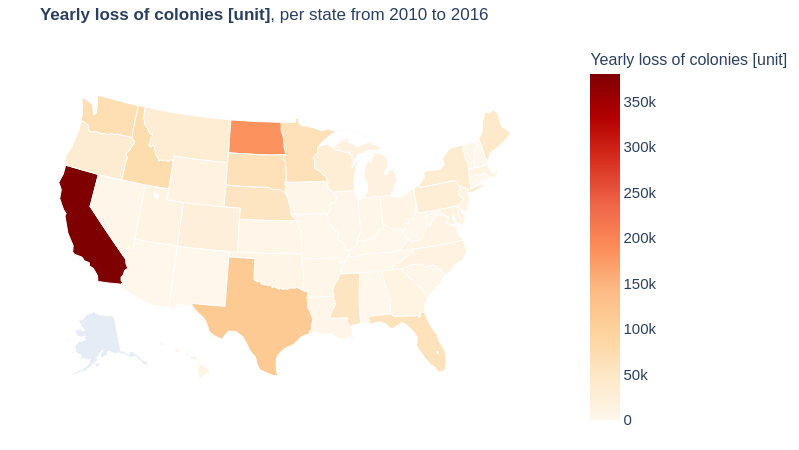

In [32]:
df = loss_per_state['colonies'].astype(float).round()

fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=df,
    locationmode='USA-states',
    colorscale='OrRd',
    marker_line_color='white',
    colorbar_tickfont_size=15,
    colorbar_title='Yearly loss of colonies [unit]',
    colorbar_title_font_size=16,
    zmin=0,
    zmax=df.max()
))

fig.update_layout(
    title_text = '<b>Yearly loss of colonies [unit]</b>, per state from 2010 to 2016',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.update_layout(
    margin=dict(l=0, r=20, t=40, b=20)
)

fig.show()

### Analysis

As we can see, the three states with the most colonies are **California**, **North-Dakota** and **Texas**. 

This makes sense because of **migratory beekeeping**. Indeed, nowadays, most of a beekeeper's revenue comes from renting his bees to polinisation. [[1]](???)

**California** produces **80% of the world's almond production** [[2]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11), and they rely heavily on honeybees for their polinization. [[3]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421). The blooming period is during the first quarter, from February to March.

Then, beekeepers move their bees to **North-Dakota** where lots of the honey is produced by gorging on alfalfa, sunflowers and clovers.

They also go to **Texas**, to polinate pumpkins and cucumbers.

Another hotspot is **Florida**, where bees are needed to polinate blueberries, tupelos and brazilian pepper, all the way from February to September. [[4]](https://www.scientificamerican.com/article/migratory-beekeeping-mind-boggling-math/)

These migratory patterns can also be seen by how many of the colonies are actually exclusive to their state (see below). 
As we can see, **very little of the colonies** (1%-14%) in those four states are exlusive to it.


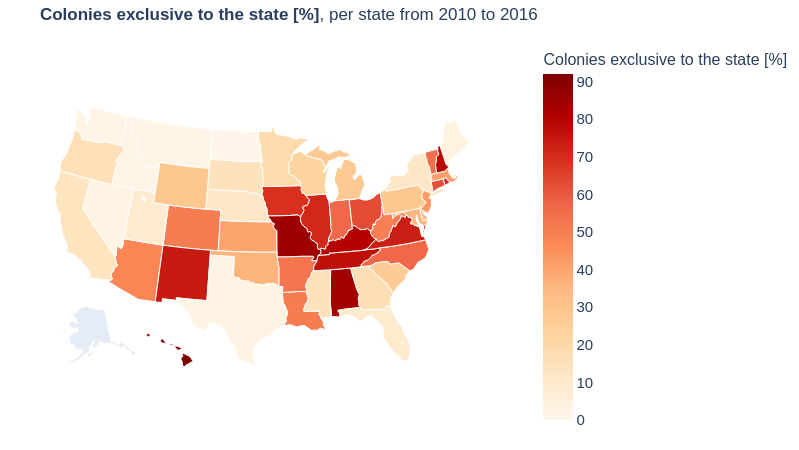

In [39]:
df = loss_per_state['colonies exclusive to state'].astype(float).apply(lambda x: x*100).round()

fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=df,
    locationmode='USA-states',
    colorscale='OrRd',
    marker_line_color='white',
    colorbar_tickfont_size=15,
    colorbar_title='Colonies exclusive to the state [%]',
    colorbar_title_font_size=16,
    zmin=0,
    zmax=df.max()
))

fig.update_layout(
    title_text = '<b>Colonies exclusive to the state [%]</b>, per state from 2010 to 2016',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.update_layout(
    margin=dict(l=0, r=20, t=40, b=20)
)

fig.show()

## Yearly loss of colonies [%]
#### 2010-2016

Now that we know where the colonies are located, where are they dying ?

We here investigate the **average yearly colony loss** for 2010-2016. That is, we want to know the percentage of colonies lost each year throughout the US.

Text(0, 0.5, 'Yearly colony loss [%]')

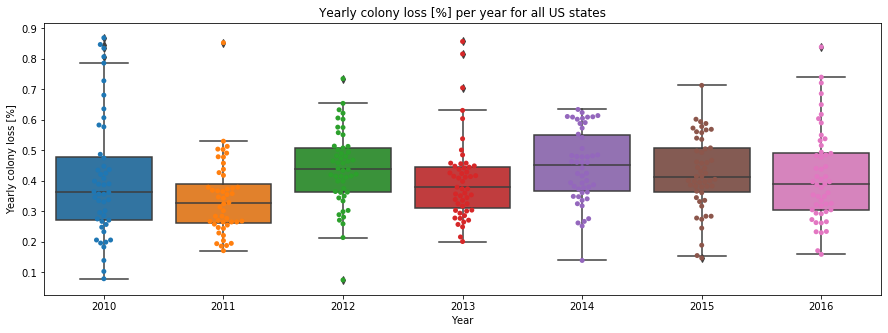

In [37]:
plt.figure(figsize=(15,5))
sns.boxplot(y='total annual loss', x='year', data=loss_all)
sns.swarmplot(y='total annual loss', x='year', data=loss_all)
plt.title('Yearly colony loss [%] per year for all US states')
plt.xlabel('Year')
plt.ylabel('Yearly colony loss [%]')

### Analysis:

In all the states, colonies are being lost. Between 2010 and 2016, the **median yearly colony loss** is roughly **stable**, albeit **very high** (~40%). Additionally, we have a **lot of variance**, with values ranging from 10% to 90%.

## Average yearly loss of colonies [%] per State
#### 2010-2016


We see in the previous boxplot that the **yearly colony losses are well spread out** (with values ranging from 10 to 90%).

We now investigate how each state compares in terms of **average yearly loss of colonies**, to see if there are any major discrepancies. That is, do some states have consistantly bigger losses ?

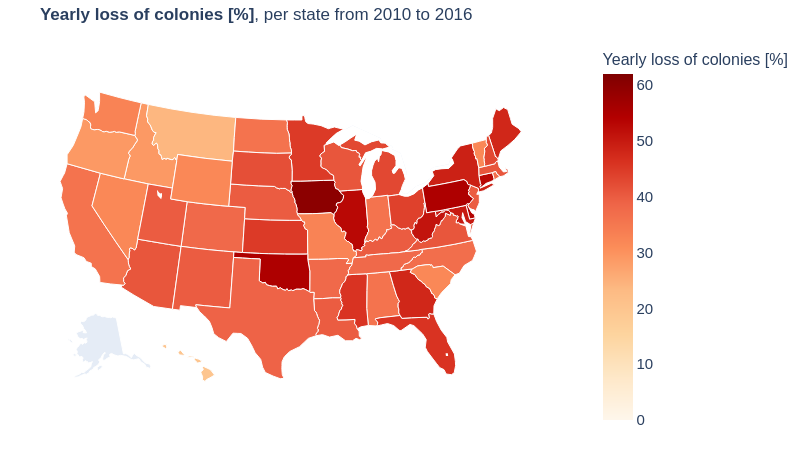

In [38]:
df = loss_per_state['total annual loss'].astype(float).apply(lambda x: round(x*100))

fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=df,
    locationmode='USA-states',
    colorscale='OrRd',
    marker_line_color='white',
    colorbar_tickfont_size=15,
    colorbar_title='Yearly loss of colonies [%]',
    colorbar_title_font_size=16,
    zmin=0,
    zmax=df.max()
))

fig.update_layout(
    title_text = '<b>Yearly loss of colonies [%]</b>, per state from 2010 to 2016',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.update_layout(
    margin=dict(l=0, r=20, t=40, b=20)
)

fig.show()

### Analysis

As we can see, the **average yearly loss** accross the US is **quite high**, and **affects all states**. There is however  **more colony loss on the east coast** than the west coast.


# Why are the bees dying ?

Now that we know where in the US they are dying, we will investigate possible reasons for this downfall.

Several factors are thought to be culprits of the CCD (Colony Collapse Disorder). Amongst which :

- Bee pests 
- Pesticide use 

We will now investigate those two factors.

## Bee pests 

Bees can be affected by several pests. The most well known of which is the **Varroa Mite**: a little bug, smaller than the bee, that attaches itself onto a bee and slowly kills it.

We will now investigate this pest.

In [40]:
varroa.head(3)

year period state  value
98   2018     Q1    AL   29.2
100  2018     Q1    AZ   36.3
102  2018     Q1    AR   21.1

In [41]:
non_varroa.head(3)

year period state  value
97   2018     Q1    AL   30.2
99   2018     Q1    AZ    4.3
101  2018     Q1    AR    9.6

## Varroa per season
#### 2015-2019

How does the fraction of colonies affected by the Varroa evolve throughout seasons ? 

Text(0, 0.5, 'Fraction of colonies affected the by Varroa [%]')

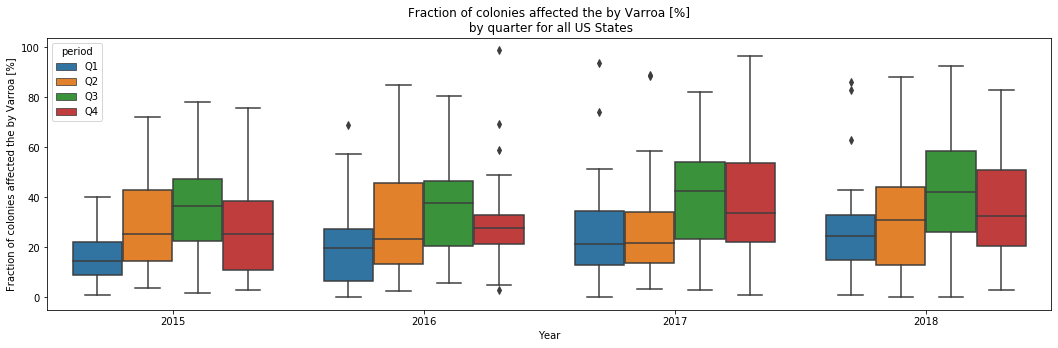

In [42]:
plt.figure(figsize=(18,5))
sns.boxplot(y='value', x='year', hue='period', data=varroa)
plt.title('Fraction of colonies affected the by Varroa [%]\n by quarter for all US States')
plt.xlabel('Year')
plt.ylabel('Fraction of colonies affected the by Varroa [%]')

### Analysis

As we can see, the **fraction of colonies infected increased from winter to summer** before plummetting in automn. This makes sense since the Varroa is sensitive to the drop in temperature.

## Fraction of colonies affected by Varroa Mites in summer and winter
#### 2015-2019

We have now seen that the Varroa Mites are the most populous in summer, but how spread out is the Varroa throughout the US ?

To answer this, we plot the fraction of colonies affected by the Varroa when it is at both peaks, i.e. in summer and winter

In [43]:
varroa_per_state = varroa.groupby(['state', 'period']).mean()['value'].reset_index()

varroa_per_state.head(3)

state period   value
0    AL     Q1  20.825
1    AL     Q2  17.350
2    AL     Q3  55.450

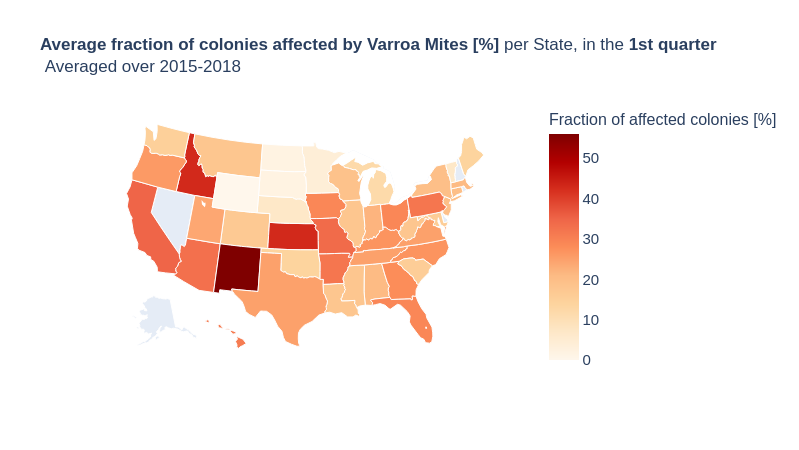

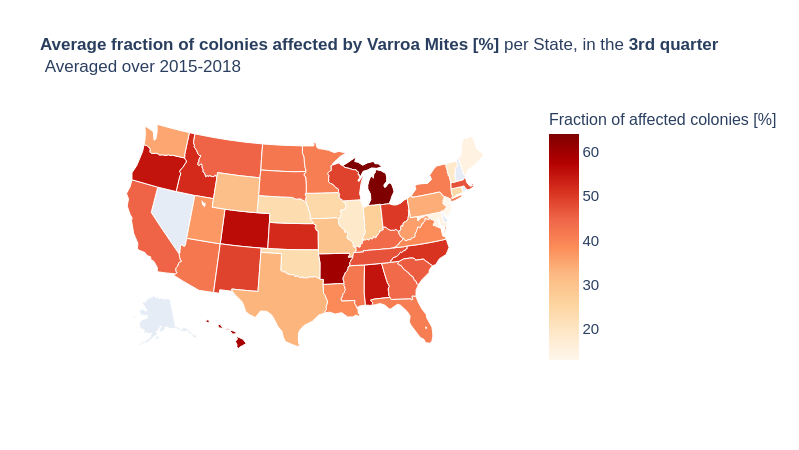

In [50]:
for quarter, word in zip(['Q1', 'Q3'], ['1st', '3rd']):
    fig = go.Figure(data=go.Choropleth(
        locations=varroa_per_state[varroa_per_state.period == quarter]['state'],
        z=varroa_per_state[varroa_per_state.period == quarter]['value'].astype(float).apply(round),
        locationmode='USA-states',
        colorscale='OrRd',
        marker_line_color='white',
        colorbar_tickfont_size=15,        colorbar_title='Fraction of affected colonies [%]',
        colorbar_title_font_size=16,
        zmin=0,
        zmax=varroa_per_state[(varroa_per_state.period == 'Q1') & (varroa_per_state.period == 'Q3')].value.max()
    ))

    fig.update_layout(
        title_text = '<b>Average fraction of colonies affected by Varroa Mites [%]</b> per State, in the <b>' + word + ' quarter</b> <br> Averaged over 2015-2018',
        geo_scope='usa', # limite map scope to USA
        dragmode=False
    )

    fig.show()

### Analysis 

Varroas are a **widespread problem**, affecting between 20 and 60% of all colonies within a state. 

In the **winter**, the Varroas of the **North-East** tend to **die off**, while the rest of the US maintains a high count of Varroas.

This is especially an issue since **California** is the **state with the most colonies** by far, and it also is one of the states with the most varroas per colonies in the winter.

Unfortunately, February to March is precisely when the almond trees bloom, and hence when the bees are in California.

## What about the other pests ?

Varroas have been a hot-topic in the bee community, but what about other pests ? Are they as widespread and as endemic ?

In [51]:
non_varroa

year period state  value
97    2018     Q1    AL   30.2
99    2018     Q1    AZ    4.3
101   2018     Q1    AR    9.6
103   2018     Q1    CA   11.3
105   2018     Q1    CO    0.8
...    ...    ...   ...    ...
1601  2015     Q4    VA   17.2
1603  2015     Q4    WA    0.1
1605  2015     Q4    WV    4.5
1607  2015     Q4    WI   15.6
1609  2015     Q4    WY    3.3

[733 rows x 4 columns]

Text(0, 0.5, 'Fraction of colonies affected the by pest \n (excluding the Varroa) [%]')

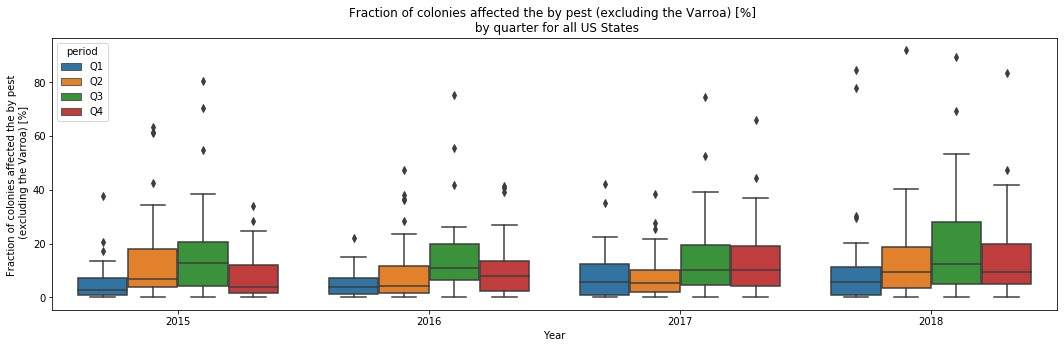

In [52]:
plt.figure(figsize=(18,5))
sns.boxplot(y='value', x='year', hue='period', data=non_varroa)
plt.title('Fraction of colonies affected the by pest (excluding the Varroa) [%] \n by quarter for all US States')
plt.xlabel('Year')
plt.ylabel('Fraction of colonies affected the by pest \n (excluding the Varroa) [%]')

## Analysis 


Other pests follow the same patterns (i.e. growing from end of the winter to summer, and dying off in winter). Additionally, they are **well widespread** throughout the US, affecting each state. However, **Varroas are more endemic**, affecting far more beehives. We however notice a lot of outliers.

## Pesticide

Another potential culprit is the use of pesticide. In 2013, Europe banned the use of neonicotinoid, a pesticide believed to contribute to CCD [[1]](https://en.wikipedia.org/wiki/Colony_collapse_disorder#Bee_rentals_and_migratory_beekeeping).

Unfortunately, the data available from the USDA concerning pesticide does not contain pesticide-specific data. Is there however similar patterns between CCD and pesticide use ?



In [53]:
pesti = pd.read_csv("data/USDA_pesticide.csv")
pesti.head()

Program  Year        Period  Week Ending Geo Level       State  State ANSI  \
0  SURVEY  2019  JAN THRU MAR          NaN  NATIONAL    US TOTAL         NaN   
1  SURVEY  2019  JAN THRU MAR          NaN     STATE     ALABAMA         1.0   
2  SURVEY  2019  JAN THRU MAR          NaN     STATE     ARIZONA         4.0   
3  SURVEY  2019  JAN THRU MAR          NaN     STATE    ARKANSAS         5.0   
4  SURVEY  2019  JAN THRU MAR          NaN     STATE  CALIFORNIA         6.0   

   Ag District  Ag District Code  County  ...  Zip Code  Region  \
0          NaN               NaN     NaN  ...       NaN     NaN   
1          NaN               NaN     NaN  ...       NaN     NaN   
2          NaN               NaN     NaN  ...       NaN     NaN   
3          NaN               NaN     NaN  ...       NaN     NaN   
4          NaN               NaN     NaN  ...       NaN     NaN   

   watershed_code  Watershed  Commodity  \
0               0        NaN      HONEY   
1               0        NaN      HONEY   
2               0        NaN      HONEY   
3               0        NaN      HONEY   
4               0        NaN      HONEY   

                                           Data Item Domain Domain Category  \
0  HONEY, BEE COLONIES, AFFECTED BY PESTICIDES - ...  TOTAL   NOT SPECIFIED   
1  HONEY, BEE COLONIES, AFFECTED BY PESTICIDES - ...  TOTAL   NOT SPECIFIED   
2  HONEY, BEE COLONIES, AFFECTED BY PESTICIDES - ...  TOTAL   NOT SPECIFIED   
3  HONEY, BEE COLONIES, AFFECTED BY PESTICIDES - ...  TOTAL   NOT SPECIFIED   
4  HONEY, BEE COLONIES, AFFECTED BY PESTICIDES - ...  TOTAL   NOT SPECIFIED   

  Value CV (%)  
0  13.6    NaN  
1   0.3    NaN  
2  16.2    NaN  
3  55.3    NaN  
4  12.3    NaN  

[5 rows x 21 columns]

In [54]:
# Clean header
pesti.columns = [column.strip().lower() for column in pesti.columns]

# lowercase the state
pesti.state = pesti.state.apply(str.lower)

# Discard the 3 rows with less than 5 hives
pesti = pesti[pesti.domain == 'TOTAL']

# Keep relevant columns
PESTI_TO_KEEP = ['year', 'period', 'state', 'value']
pesti = pesti[PESTI_TO_KEEP]

# Replace month ranges by quarters
pesti.replace(to_replace=quarters, inplace=True)

# Discard rows where the value wasn't reported 
pesti = pesti[pesti.value.apply(lambda x: x != ' (Z)')] # only keep US states
pesti.value = pesti.value.apply(float)

# Replace state by 2-letters symbol
pesti.replace(to_replace=states, inplace=True)

# only keep US states
pesti = pesti[pesti.state.apply(lambda x: x in states.values())] 

# Discard 2019
pesti = pesti[pesti.year != 2019]

In [55]:
pesti.head(3)

year period state  value
48  2018     Q1    AL   14.9
49  2018     Q1    AZ   15.3
50  2018     Q1    AR   23.0

In [56]:
pesti_per_state = pesti.groupby(['state', 'period']).mean().reset_index()

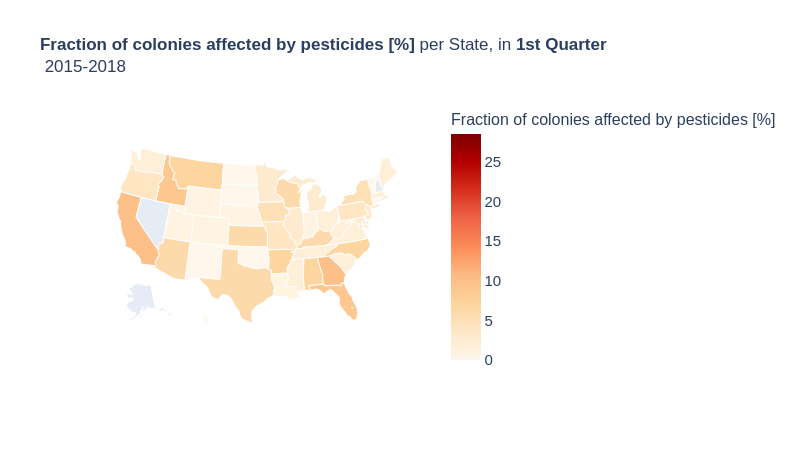

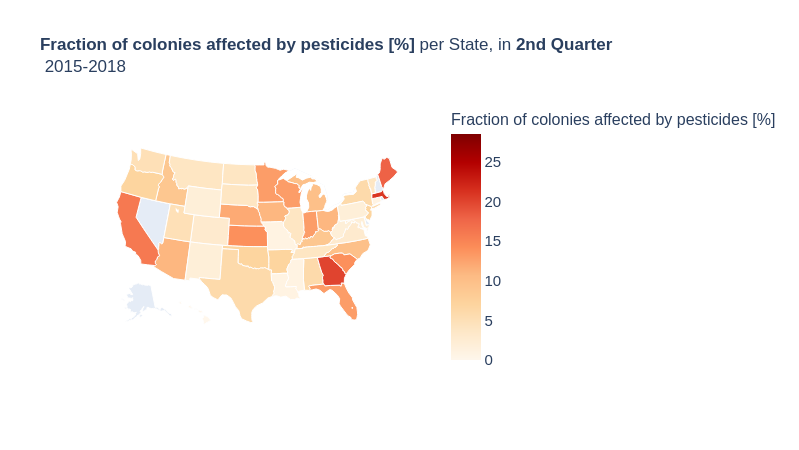

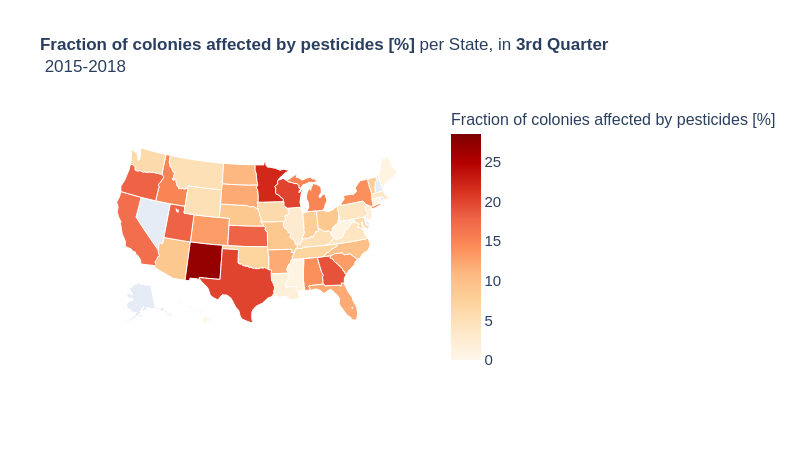

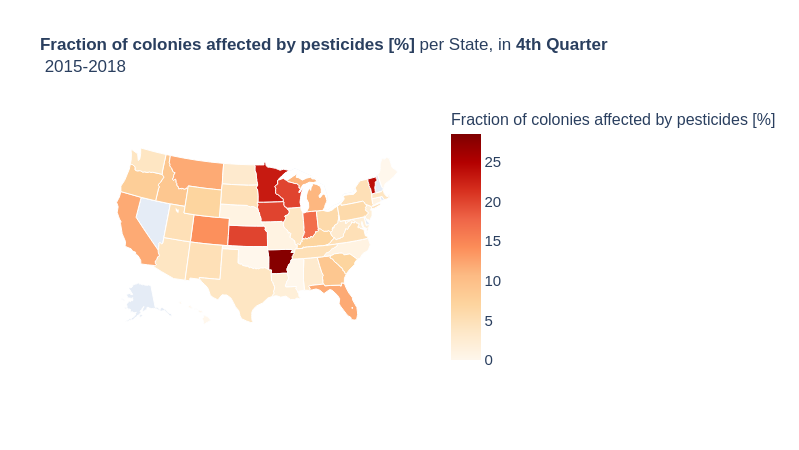

In [59]:
for quarter, word in zip(['Q1', 'Q2', 'Q3', 'Q4'], ['1st', '2nd', '3rd', '4th']):
    fig = go.Figure(data=go.Choropleth(
        locations=pesti_per_state[pesti_per_state.period == quarter]['state'],
        z=pesti_per_state[pesti_per_state.period == quarter]['value'].astype(float).apply(round),
        locationmode='USA-states',
        colorscale='OrRd',
        colorbar_title='Fraction of colonies affected by pesticides [%]',
        marker_line_color='white',
        colorbar_tickfont_size=15,
        colorbar_title_font_size=16,
        zmin=0,
        zmax=pesti_per_state.value.max()
    ))

    fig.update_layout(
        title_text = '<b>Fraction of colonies affected by pesticides [%]</b> per State, in <b>' + word + ' Quarter</b> <br> 2015-2018',
        geo_scope='usa', # limite map scope to USA
        dragmode=False
    )

    fig.show()

### Analysis 

Pesticide levels increase from the 1st to the 3rd quarter all over the US. But is there a correlation ?

We investigate below the pesticide levels per colony losses to see if we can see a meaningful correlation.



In [58]:
# We average over the period, since we only have annual data for the colony losses
pesti_per_year = pesti.groupby(['year', 'state']).mean().reset_index()


In [126]:
pesti_per_year = pd.merge(pesti_per_year, loss_all[['year', 'state', 'total annual loss']], on=['year', 'state'])

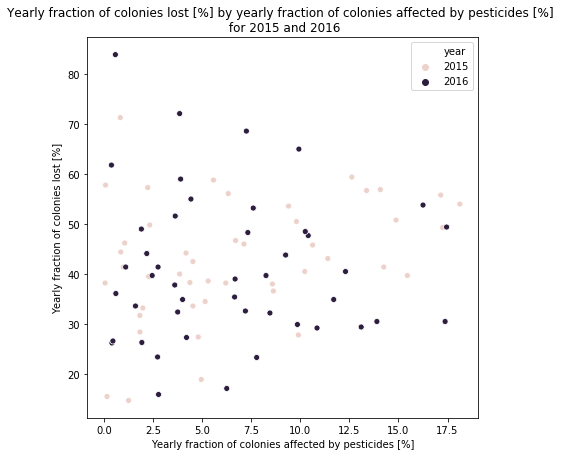

In [127]:
plt.figure(figsize=(7,7))
sns.scatterplot(x='value', y='total annual loss', hue='year', data=pesti_per_year, legend='full')
plt.xlabel('Yearly fraction of colonies affected by pesticides [%]')
plt.ylabel('Yearly fraction of colonies lost [%]')
plt.title('Yearly fraction of colonies lost [%] by yearly fraction of colonies affected by pesticides [%] \n for 2015 and 2016')
plt.show()

### Analysis

We see no correlation between the fraction of colonies affected by pesticides and the fraction of colony lost. 

This however does not discredit the pesticide theory. One specific pesticide (neonicotinoids) is thought to be one of the culprit of CCD. Unfortunately, our dataset aggregates all the pesticides together. The lack of correlation could be due to the use of both bee-harming and non-bee-harming pesticides.

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Calfornia has been producing more than 80% of the world almond production for many years, and is the only state that harvests almonds in the US. [[1]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11), [[3]](http://www.almonds.com/sites/default/files/Almond_Almanac_2018_F_revised.pdf). The almond tree is one of the many crops that require cross-pollination for it to bear fruits. It is simple, as almonds flowers are in bloom for a very short period of time (only some days), a lack of pollinators during this time frame would results in desastrous harvests. Thus, they and especially honey bees play a central and vital role in growing almonds. [[2]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421). Almond growers need to play hand in hand with bee keepers in order to ensure plentiful harvests. We first show the current contribution of bees to this industry, then we try to look into the effect of bee on the productivity from the 00's to 2017.

### 5.1 Loading Datasets
#### 5.1.1 Loading almond production dataset
This is a subset of the data from the [USDA](https://quickstats.nass.usda.gov/) dataset

In [128]:
california_almond = pd.read_excel('data/california_USDA_almond.xlsx', skiprows=[22], index_col='year')
california_almond.tail()

bearing  non_bearing  yield_per_acre  production  price_per_pound  \
year                                                                      
2013   880000       120000            2280        2010             3.21   
2014   930000       170000            2010        1870             4.00   
2015   950000       240000            2000        1900             3.13   
2016   970000       300000            2210        2140             2.44   
2017  1030000       330000            2200        2270             2.53   

      value_of_production  
year                       
2013              6384690  
2014              7388000  
2015              5868750  
2016              5052460  
2017              5603950

**Notes** on the above dataset:
- bearing, non_bearing are in acres => we want to convert into hectares (10'000 $m^2$)
- yield per acre is in pounds => we want to convert into kg/hectares
- production is in million of pounds => we want to convert into kg
- price is in \$/pound => we want to convert into kg
- value of production is thousands of \$

**Non-bearing acres** are usually areas with trees that are too young to bear fruits, as tree reaches maturity after 5-6 years [[1]](https://en.wikipedia.org/wiki/Almond#Tree)

In [129]:
HECTARE_PER_ACRE = 0.404686
KG_PER_POUND = 0.453592

# Convertion acre => hectare
california_almond.bearing *= HECTARE_PER_ACRE
california_almond.non_bearing *= HECTARE_PER_ACRE
california_almond.yield_per_acre /= HECTARE_PER_ACRE

# Convertion pound => kg
california_almond.yield_per_acre *= KG_PER_POUND
california_almond.production *= KG_PER_POUND
california_almond.price_per_pound /= KG_PER_POUND

In [130]:
# Add total harvested area
california_almond['total'] = california_almond.bearing + california_almond.non_bearing

#### 5.1.2 Loading the rest of the almond dataset from USDA
Here we only keep some columns from the dataset that are containing the relevant information of the type:
- Program: Survey (usually every year) / Census (1992, 2012, 2017)
- Time Data: Year, Period
- Geo Data: Geo Level, State, Region
- Field descriptors: Data Item, Domain, Domain Category
- Value field: Value

In [131]:
col_to_keep_almond = ['Program' , 'Year', 'Period', 'Geo Level', 'State', 'Region', 'Data Item', 'Value', 'Domain', 'Domain Category']
almond_df = pd.read_csv('data/USDA_almond.csv', usecols=col_to_keep_almond)

#### 5.1.3 Loading bee inventory from USDA
We keep columns in a similar fashion as in 5.1.2

In [132]:
def parse_number(number):
    """ Helper to parse american style number to int """
    if type(number) is np.int:
        return number
    if re.search(r'[DZ]', number): # as in 4, (D), (Z) are not significant
        return 0
    try:
        return int(re.sub(r"[,'_]", "", number))
    except:
        print('Error while parsing:', number)
        return np.nan

In [133]:
col_to_keep_bee = ['Program' , 'Year', 'Period', 'Geo Level', 'State', 'Data Item', 'Value', 'Domain', 'Domain Category']
bee_colony_df = pd.read_csv('data/USDA_bee_colony.csv', usecols=col_to_keep_bee)
bee_colony_df.Value = bee_colony_df.Value.apply(parse_number)

### 5.2 Contribution of bees
We first look into the effect of commercial honey bee pollination. The data is limited from 2015-2017, but it should gives us insights on where to look further in the dataset. We can explore it in 5 directions shown in the list below.

In [134]:
pollination = ['ALMONDS, HONEY BEE POLLINATION - ACRES POLLINATED, PAID BASIS',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN $ / ACRE',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN $ / COLONY',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN COLONIES',
               'ALMONDS, HONEY BEE POLLINATION - VALUE OF POLLINATION, MEASURED IN $']

In [135]:
pollination_df = almond_df[almond_df['Data Item'].isin(pollination)]\
                 .drop(columns=['Program', 'Period', 'Geo Level', 'State', 'Domain', 'Domain Category'])\
                 .copy()
pollination_df.Value = pollination_df.Value.apply(parse_number)

pollination_df['Data Item'] = pollination_df['Data Item'].apply(lambda x: x.lstrip('ALMONDS, HONEY BEE POLLINATION')[2:])

In [136]:
pollination_pivot = pollination_df.pivot(index='Year', columns='Data Item', values='Value')
pollination_pivot

Data Item  ACRES POLLINATED, PAID BASIS  POLLINATION, MEASURED IN $ / ACRE  \
Year                                                                         
2015                             921200                                313   
2016                             921400                                287   
2017                             928600                                272   

Data Item  POLLINATION, MEASURED IN $ / COLONY  \
Year                                             
2015                                       165   
2016                                       167   
2017                                       171   

Data Item  POLLINATION, MEASURED IN COLONIES  \
Year                                           
2015                                 1760000   
2016                                 1590000   
2017                                 1480000   

Data Item  VALUE OF POLLINATION, MEASURED IN $  
Year                                            
2015                                 290400000  
2016                                 265530000  
2017                                 253080000

**Insights**:
1. By giving a look at the data from 5.1.1 we observe that acres pollinated $\sim$ bearing area
2. It requires a high amount of colonies (1.48 to 1.76 million)
3. It costs almond growers about 250-290 millions \$ per year, which is about 5\% of the value of production
4. The price per colony is rougly constant (given the current inflation in the US)
5. In general there seems to be a decreasing amount of colonies per acres as the number of acres is constant but the number of colonies is droping. Resulting in a drop of price per acre and total cost

*Point 1*: We first compare the acres pollinated and the acres bearing

In [137]:
(pollination_pivot['ACRES POLLINATED, PAID BASIS'].apply(lambda x: x * HECTARE_PER_ACRE)
 / california_almond.bearing).dropna()

2015    0.969684
2016    0.949897
2017    0.901553
dtype: float64

We see that bees are present on more than 90% of the bearing area, this means that almond growers heavily rely on honey bees for the cross-pollination of their crops.

### 5.3 Almond production
We then dive into almond production. We would like to be able to compare the production, area bearing/non-bearing and price in order to identify patterns and particularities.

In [138]:
def autolabel(rects, ax, labels):
    """
    Attach a text label above each bar in *rects*, displaying a given label.
    Code adapted from [matplotlib doc](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)
    """
    for rect, label in zip(rects, labels):
        ax.annotate('{:.1f}'.format(label),
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

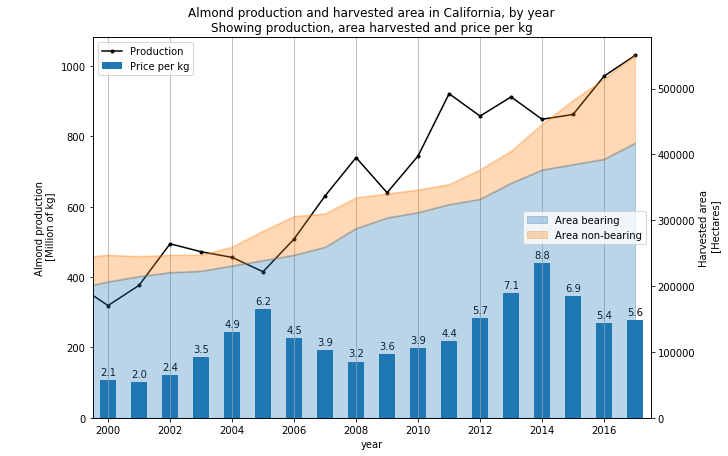

In [139]:
# Plots
fig, ax1 = plt.subplots(figsize=(10, 7))
prod_plt = california_almond.plot(y='production', style='k.-', ax=ax1, legend=True, label='Production')
price_bar = ax1.bar(x=california_almond.index, height=california_almond.price_per_pound*50, width=0.5, label='Price per kg')
autolabel(price_bar, ax1, california_almond.price_per_pound)
ax2 = ax1.twinx()
area_plt = california_almond.plot(y=['bearing', 'non_bearing'], kind='area', stacked=True, alpha=0.3, ax=ax2, legend=True, label=['Area bearing', 'Area non-bearing'])
ax2.legend(loc='center right')
ax1.legend()

plt.xlim(left=1999.5, right=2017.5)
plt.title('Almond production and harvested area in California, by year\nShowing production, area harvested and price per kg')
ax1.grid(axis='x')
plt.xlabel('Year')
#ax1.set_yscale('log')
ax1.set_ylabel('Almond production\n [Million of kg]')
ax2.set_ylabel('Harvested area\n [Hectares]')
plt.show()

**Analysis**:
1. We see that the bearing area for almonds is stricly increasing, this indicates that the industry has become more and more popular (and lucrative).
2. In the recent years, the non-bearing area has increased because farmers are replacing old trees with new varieties of more resistant, less water-consuming and even sometimes self-polinating varieties [[1]](http://www.almonds.com/processors/resources/almond-almanac)
3. We identify a high correlation (see plot below) of 0.95 between the bearing area and production
    - This clearly is a causation effect, the more area bears fruit the more almonds are available
    - Yet, we identify some outliers like sudden drops in 2009 and plateaux from 2002-2005 and 2011-2015. This needs further investigating.
4. The price has a pretty low positive correlation coefficient with the production.
    - E.g. there's a high price increase in 2014 whereas the production remained roughly stable
    - The price of almonds actually depends on other factors such as exportation and demand from foreign markets [[2]](https://www.bls.gov/opub/btn/volume-6/the-rise-and-fall-of-almond-prices-asia-drought-and-consumer-preference.htm), but we did not succeed at finding articles linking the prices of almonds to the cost of pollination

**Further analysis of production plateau and drop**
There are two main factors to decrease in almond production: a **lack of pollinators** and **water shortage**
- The 2002-2005 plateau:
    >California almond growers are once again being stung by a shortage of honeybees. [[3]](https://www.latimes.com/archives/la-xpm-2005-may-07-fi-almonds7-story.html)
    - This plateau is caused by a lack of pollinators
    - These years are also the first important reports of Colony Collapse Disorder in the media
    - The almond industry had become more dependent on migratory beekeeping (which began developping around that time)
- The 2009 drop:
    - California had been experiencing a drought and many almond growers could not irriguate their crops [[4]](https://www.growingproduce.com/fruits/impacts-of-drought-on-almond-production/)
- The 2011-2015 plateau:
    - California again experienced severe drought [[5]](https://www.growingproduce.com/fruits/impacts-of-drought-on-almond-production/)
    - What improved the situation:
        - New pollinators initiative have been undertaken to reduce the risk of a lack of pollinators, since 2014, [Honey Bee best Management Practices](http://www.almonds.com/pollination) describes how to promote discussion between beekeepers and almond growers
        - Less water consuming almond trees were planted in the wake of the 2009 drought and started to bear fruits

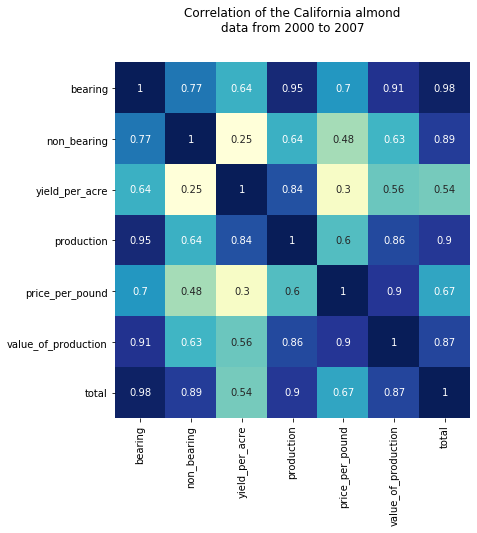

In [140]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(california_almond[california_almond.index >= 2000].corr(), annot=True, ax=ax, cbar=False, cmap='YlGnBu', square=True)
ax.set_ylim(7, -0.5)
plt.title('Correlation of the California almond\ndata from 2000 to 2007')
plt.show()

### 5.4 Bees

We finally look into the bee population and the necessary migratory beekeeping in order to sustain the almond agriculture

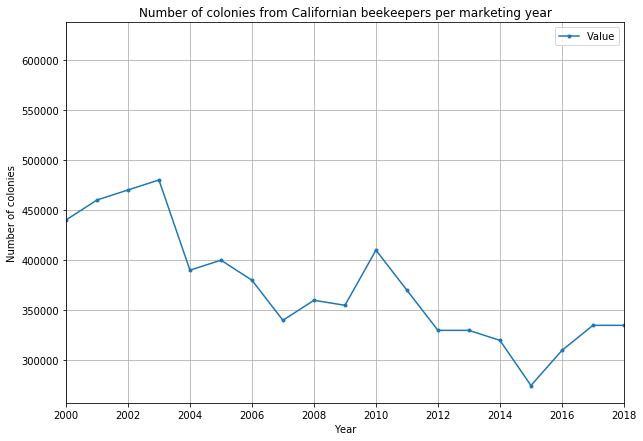

In [141]:
condition = {'Geo Level': 'STATE', 'State': 'CALIFORNIA', 'Program': 'SURVEY', 'Period': 'MARKETING YEAR'}
CAL_colony = bee_colony_df[np.all([(bee_colony_df[key] == value) for key, value in condition.items()], axis=0)].set_index('Year')
CAL_colony.plot(y='Value', style='.-', figsize=(10, 7))
plt.title('Number of colonies from Californian beekeepers per marketing year')
plt.ylabel('Number of colonies')
plt.xlim(left=2000)
plt.grid()
plt.show()

We can clearly see that there is not enough *local* colonies to sustain the almond agriculture, with currently **less than 350'000 colonies** when the almond industry requires about **1'500'000 colonies**. This means that **at least three quarters** of the colonies need to be brought to California in order to supply the industry.

If we assume that the amount of colonies per hectare is roughly constant, we can say that California was never self-sufficient in bee colonies required for almonds during the 21st century, prompting other states beekeepers to move around the US with their colonies as the pollination price increased and started representing half of a beekeeper's revenue.

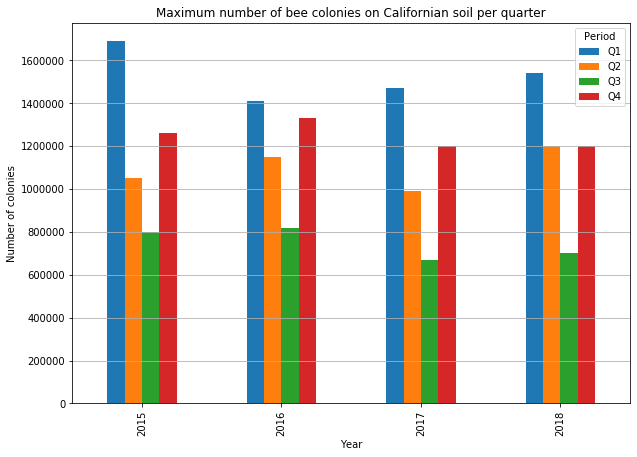

In [142]:
condition = {'Geo Level': 'STATE', 'State': 'CALIFORNIA', 'Program': 'SURVEY', 'Data Item': 'HONEY, BEE COLONIES - INVENTORY, MAX, MEASURED IN COLONIES'}
map_period = {'JAN THRU MAR': 'Q1', 'APR THRU JUN': 'Q2', 'JUL THRU SEP': 'Q3', 'OCT THRU DEC': 'Q4'}
CAL_colony_max = bee_colony_df[np.all([(bee_colony_df[key] == value) for key, value in condition.items()], axis=0) & (bee_colony_df.Year < 2019)].copy()
CAL_colony_max.Period = CAL_colony_max.Period.map(map_period)

CAL_colony_max.pivot(index='Year', columns='Period', values='Value').plot.bar(figsize=(10, 7))

plt.title('Maximum number of bee colonies on Californian soil per quarter')
plt.ylabel('Number of colonies')
plt.grid(axis='y')
plt.show()

We can clearly see that the maximum number of bee colonies on Californian soil far exceed the number of local colonies. This is especially true during Quarter 1 (January through March) when the almond tree bloom (mid-february). We see that during Q1, the number of colonies meets the demand of the almond industry. During the other quarters, there is less colonies in California as, as seen in Research Question 4, the beekeepers are busy in other states with their bees.

### 5.5 Conclusion
It is clear that bees play a central role in pollinating almond trees being present in more than 90% of the bearing orchads. A lack of bees results in a stagnant almond production but is not the only factor to take into account, as California is more and more exposed to extreme weather and drought. Thus, almond growers need to rely on migratory beekeepers for the pollination and new varieties of trees to face the future.

# Plan

## Week of 02.12.2019

- Find a way to tie all of our analysis and abstract together in a coherent story arc
- Learn how to use [Beautiful Jekyll](https://deanattali.com/beautiful-jekyll/) for our data story
- Learn how to use Plotly
- Prepare our *Github page*

## Week of 09.12.2019

- Implement convincing and insightful visualizations:
    - Interactive scatter plot between number of beehives and honey production for selected countries moving through the years
    - Heat map of the US with a toggle for the type of pest (Varroa, ...) and the desired quarter
    - ...
- Write a draft of our data story descriptions
    
## Week of 16.12.2019

- Complete our data story with inspiring descriptions of our data analysis
- Finalize Milestone 3

## Weeks until 20.01.2020

- Prepare the presentation
- Team practive for the presentation
- Print our poster

# Questions to TAs

- What should be the appropriate length for a data story? How much time should someone take to read it?

# New visualizations for Milestone 3

For more analysis and details, visit our datastory https://indigo-vanguard.github.io/ .

### Can we find a single culprit for this collapse?



In [61]:
varroa_per_year = varroa.groupby(['year', 'state']).mean().reset_index()
non_varroa_per_year = non_varroa.groupby(['year', 'state']).mean().reset_index()
pesti_per_year = pesti.groupby(['year', 'state']).mean().reset_index()

In [62]:
varroa_per_year = pd.merge(varroa_per_year, loss_all[['year', 'state', 'total annual loss']], on=['year', 'state'])
non_varroa_per_year = pd.merge(non_varroa_per_year, loss_all[['year', 'state', 'total annual loss']], on=['year', 'state'])
pesti_per_year = pd.merge(pesti_per_year, loss_all[['year', 'state', 'total annual loss']], on=['year', 'state'])

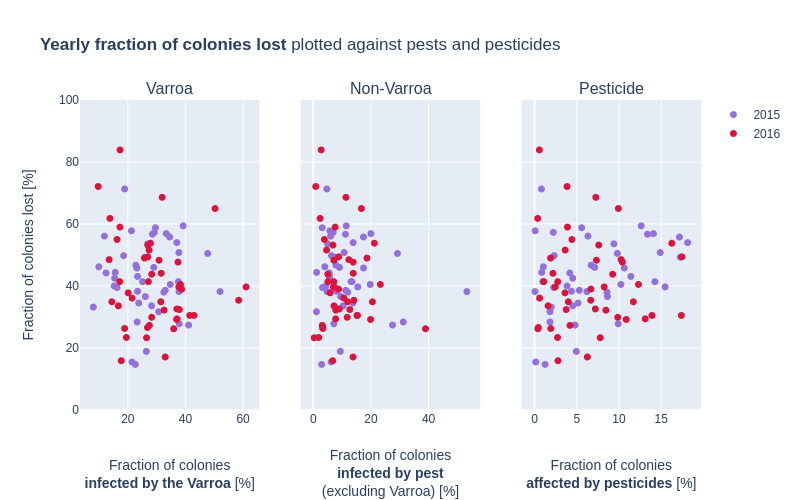

In [65]:
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

f = make_subplots(1, 
                  3, 
                  shared_yaxes=True,
                  subplot_titles=("Varroa", "Non-Varroa", "Pesticide"))

f.update_layout(
    title="<b>Yearly fraction of colonies lost</b> plotted against pests and pesticides",
    width=700,
    height=500,
    yaxis_title='Fraction of colonies lost [%]'
)  

xlabels = ['Fraction of colonies<br><b>infected by the Varroa</b> [%]', 'Fraction of colonies<br><b>infected by pest</b><br>(excluding Varroa) [%]', 'Fraction of colonies<br><b>affected by pesticides</b> [%]']

markers = {
    2015: dict(color="MediumPurple", size=7),
    2016: dict(color="Crimson", size=7)
}

showlegend = False

for i, df, xlabel in zip(range(3), [varroa_per_year, non_varroa_per_year, pesti_per_year], xlabels):
    for year, year_data in df.groupby('year'):
        if i == 2:
            showlegend = True
            
        f.add_scatter(x=year_data.value, 
                      y=year_data['total annual loss']*100, 
                      name=year, 
                      text=year_data['state'],
                      hoverinfo='x+y+name+text',
                      mode='markers', 
                      row=1, 
                      col=i+1,
                      marker=markers[year],
                      showlegend=showlegend,)

        f.update_xaxes(title_text=xlabel, row=1, col=i+1)
        f.update_yaxes(range=[0, 100])

#plotly.offline.plot(f, filename='scatterplot_lack_of_correlation.html', image_width=300, image_height=100)
        
f.show()

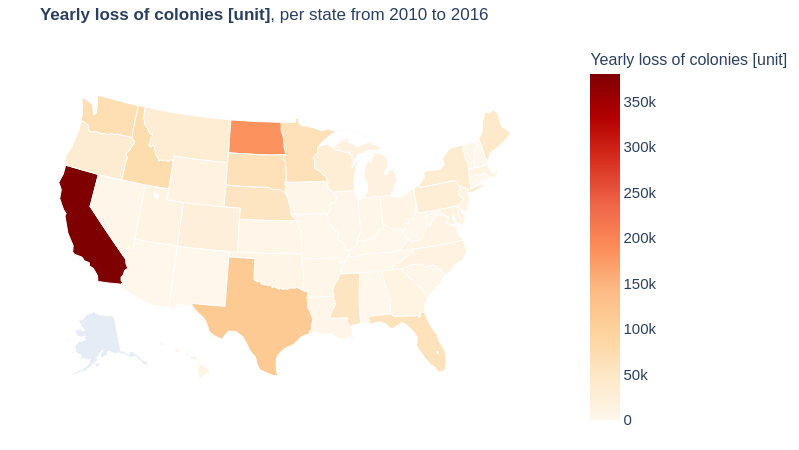

In [64]:
df = loss_per_state['colonies'].astype(float).round()

fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=df,
    locationmode='USA-states',
    colorscale='OrRd',
    marker_line_color='white',
    colorbar_tickfont_size=15,
    colorbar_title='Yearly loss of colonies [unit]',
    colorbar_title_font_size=16,
    zmin=0,
    zmax=df.max()
))

fig.update_layout(
    title_text = '<b>Yearly loss of colonies [unit]</b>, per state from 2010 to 2016',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.update_layout(
    margin=dict(l=0, r=20, t=40, b=20)
)

#plotly.offline.plot(fig, filename='yearly_loss_of_colonies_unit.html', image_width=100, image_height=100)

fig.show()

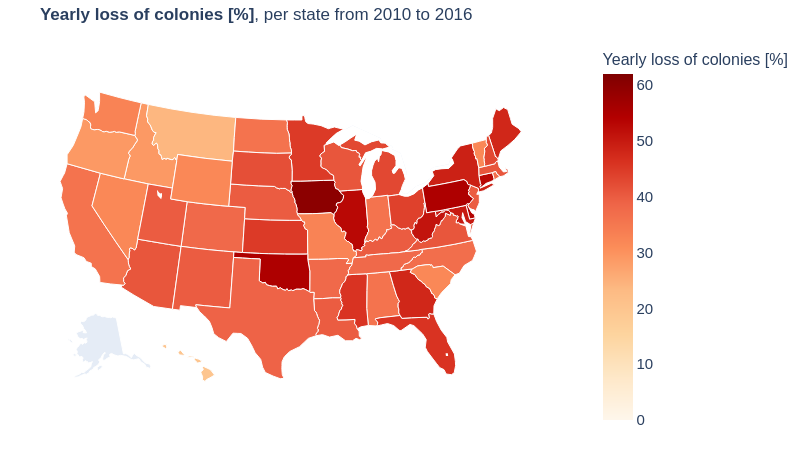

In [66]:
df = loss_per_state['total annual loss'].astype(float).apply(lambda x: round(x*100))

fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=df,
    locationmode='USA-states',
    colorscale='OrRd',
    marker_line_color='white',
    colorbar_tickfont_size=15,
    colorbar_title='Yearly loss of colonies [%]',
    colorbar_title_font_size=16,
    zmin=0,
    zmax=df.max()
))

fig.update_layout(
    title_text = '<b>Yearly loss of colonies [%]</b>, per state from 2010 to 2016',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.update_layout(
    margin=dict(l=0, r=20, t=40, b=20)
)

#plotly.offline.plot(fig, filename='yearly_loss_of_colonies_percent.html', image_width=100, image_height=100)

fig.show()

### The life of an American bee in February

In [143]:
beehives = pd.read_csv('data/FAOSTAT_Live_Stock.csv')[['Year', 'Area', 'Value']].set_index(['Year', 'Area'])
beehives.index.is_unique

True

In [144]:
honey = pd.read_csv('data/FAOSTAT_Livestock_Primary.csv')
honey = honey[(honey.Element == 'Production') & (honey.Item.str.startswith('Honey'))][['Year', 'Area', 'Value']]
honey['Country'] = honey.Area
honey.set_index(['Year', 'Area'], inplace=True)
honey.index.is_unique

True

In [145]:
beehive_honey = beehives.join(honey, how='inner', lsuffix='_bee', rsuffix='_honey').sort_index().dropna()#.reset_index()
beehive_honey = beehive_honey[(beehive_honey['Value_honey'] > 0) & (beehive_honey['Value_bee'] > 0)].copy()
beehive_honey['Productivity'] = beehive_honey['Value_honey'] * 1000 / beehive_honey['Value_bee']

In [146]:
beehive_honey.Productivity.describe()

count      5916.000000
mean        939.241779
std       21282.628141
min           0.512996
25%           9.737372
50%          15.000282
75%          24.904508
max      750000.000000
Name: Productivity, dtype: float64

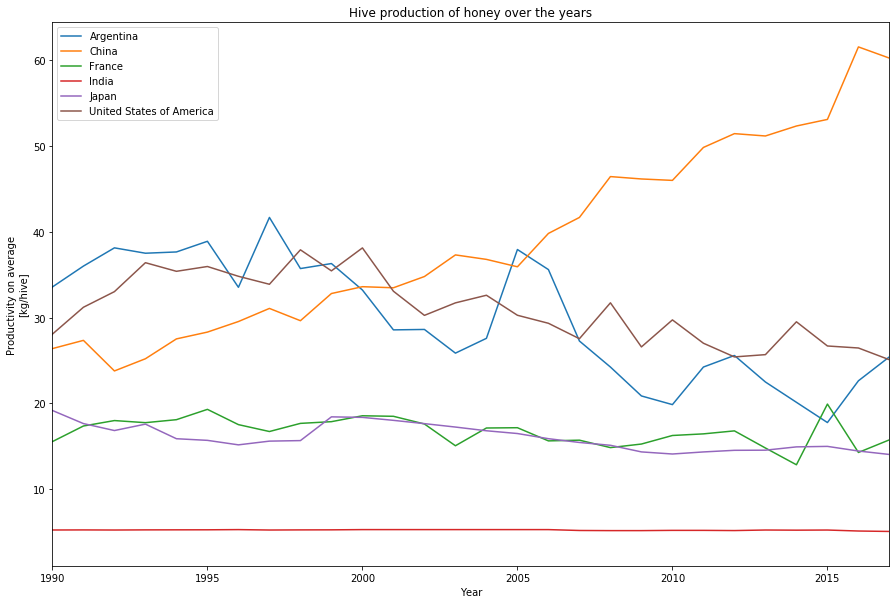

In [147]:
list_country = {'China', 'United States of America', 'France', 'Japan', 'Argentina', 'India'}
fig, ax = plt.subplots(figsize=(15,10))
group = beehive_honey[beehive_honey.Country.isin(list_country)][['Country', 'Productivity']].reset_index('Area').groupby('Country')

group.plot(ax=ax) #[beehive_honey.Country.isin(list_country)]
ax.legend(sorted(list_country))
ax.set_ylabel('Productivity on average\n[kg/hive]')
ax.set_xlim(left=1990)
ax.set_title('Hive production of honey over the years')
plt.show()

In [148]:
country_code = pd.read_csv('data/UN_country.csv', usecols=['Area', 'Code'], index_col='Area')

In [149]:
beehive_honey = beehive_honey.reset_index('Year').join(country_code)

In [150]:
beehive_honey[beehive_honey.Code.isnull()].Country.unique()

array(['Belgium-Luxembourg', 'China', 'Palestine',
       'Serbia and Montenegro', 'Yugoslav SFR'], dtype=object)

In [151]:
beehive_honey = beehive_honey[~beehive_honey.Code.isnull()]

In [152]:
beehive_honey_clean = beehive_honey.reset_index()
beehive_honey_clean = beehive_honey_clean[(beehive_honey_clean.Productivity < 70) & (beehive_honey_clean.Year >= 1990)]

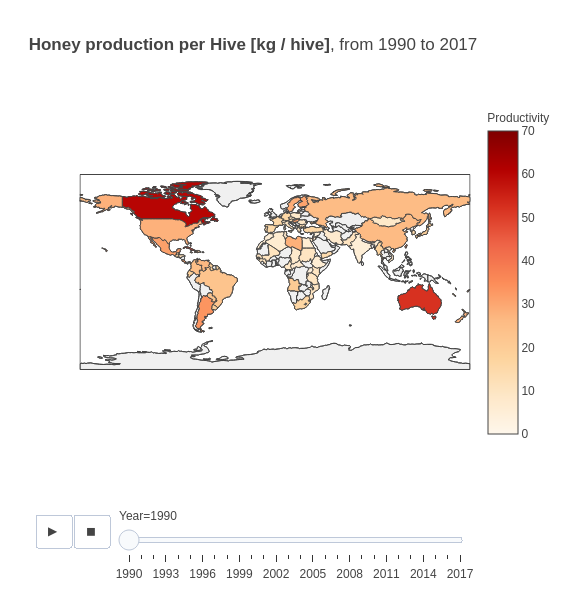

In [153]:
layout = dict(layout=dict(geo=layout.Geo(showcountries=True, showlakes=False, showland=True, landcolor='#f0f0f0')))
fig = px.choropleth(beehive_honey_clean, locations="Code", color="Productivity", hover_name="Country", animation_frame="Year",
                    color_continuous_scale=px.colors.sequential.OrRd, title='<b>Honey production per Hive [kg / hive]</b>, from 1990 to 2017',
                    range_color=[0,70], height=600, template=layout)

fig.update_layout(
    title={'x':0.05, 'xanchor': 'left'})
fig.show()

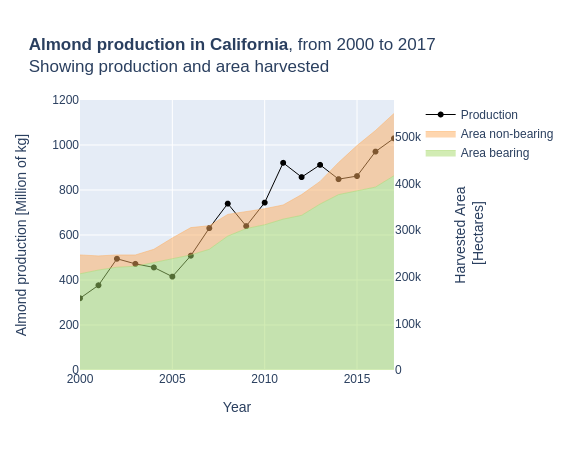

In [154]:
x=np.arange(2000, 2018)

fig =  make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=x, y=california_almond.bearing[x],
    name='Area bearing',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(166,217,106)'),
    stackgroup='one'),
    secondary_y=True
)
fig.add_trace(go.Scatter(
    x=x, y=california_almond.non_bearing[x],
    name='Area non-bearing',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(253,174,97)'),
    stackgroup='one'),
    secondary_y=True
)
fig.add_trace(go.Scatter(
    x=x, y=california_almond.production[x],
    name='Production',
    hoverinfo='name+x+y',
    line=dict(width=1, color='black')
    ),
    secondary_y=False
)

fig.update_layout(title='<b>Almond production in California</b>, from 2000 to 2017<br>Showing production and area harvested',
                  xaxis_title="Year")
fig.update_xaxes(range=(2000, 2017))
fig.update_yaxes(title_text='Almond production [Million of kg]', range=(0, 1200), secondary_y=False)
fig.update_yaxes(title_text="Harvested Area<br> [Hectares]", showgrid=False, secondary_y=True)
fig.show()

### Shedding the light on dirty honey tricks

In [155]:
# Gather beehives informations.
beehives_raw = pd.read_csv('data/FAOSTAT_Live_Stock.csv')
beehives_raw = beehives_raw[['Area', 'Year', 'Value']]
beehives_raw = beehives_raw.rename(columns={'Value': 'Number of beehives'})
beehives_raw = beehives_raw[beehives_raw.Year >= 1990]  # Keep only from 1990 onwards
beehives_raw['id'] = beehives_raw['Area'] + beehives_raw['Year'].apply(str)
beehives_raw = beehives_raw.set_index('id')
beehives_raw.head()

Area  Year  Number of beehives
id                                            
Albania1990  Albania  1990             80000.0
Albania1991  Albania  1991             72900.0
Albania1992  Albania  1992             36200.0
Albania1993  Albania  1993             20000.0
Albania1994  Albania  1994             26900.0

In [156]:
# Countries and continents applied to beehives
countries = pd.read_csv('data/countries.csv')
countries = countries[['name', 'region']].set_index('name')
print('Are the countries in the dataset unique? -> %s\n' % countries.index.is_unique)
countries.loc['Belgium-Luxembourg'] = 'Europe'
countries.loc['China, mainland'] = 'Asia'
countries.loc['China, Taiwan Province of'] = 'Asia'
countries.loc['Czechoslovakia'] = 'Europe'
countries.loc['Ethiopia PDR'] = 'Africa'
countries.loc['Palestine'] = 'Asia'
countries.loc['Republic of Korea'] = 'Asia'
countries.loc['Republic of Moldova'] = 'Europe'
countries.loc['Serbia and Montenegro'] = 'Europe'
countries.loc['Sudan (former)'] = 'Africa'
countries.loc['United Kingdom'] = 'Europe'
countries.loc['United Republic of Tanzania'] = 'Africa'
countries.loc['USSR'] = 'Europe'
countries.loc['Wallis and Futuna Islands'] = 'Oceania'
countries.loc['Yugoslav SFR'] = 'Europe'

print(countries['region'].value_counts())
beehives_raw['Continent'] = beehives_raw.apply(lambda row: countries.loc[row['Area']], axis=1)
beehives_raw.head()

Are the countries in the dataset unique? -> True

Africa      63
Europe      58
Americas    57
Asia        55
Oceania     30
Name: region, dtype: int64


Area  Year  Number of beehives Continent
id                                                      
Albania1990  Albania  1990             80000.0    Europe
Albania1991  Albania  1991             72900.0    Europe
Albania1992  Albania  1992             36200.0    Europe
Albania1993  Albania  1993             20000.0    Europe
Albania1994  Albania  1994             26900.0    Europe

In [157]:
honey_raw = pd.read_csv('data/FAOSTAT_Livestock_Primary.csv')
honey_raw = honey_raw[(honey_raw.Element == 'Production') & (honey_raw.Item.str.startswith('Honey'))][['Area', 'Year', 'Value']]
honey_raw = honey_raw.rename(columns={'Value': 'Honey Production [tonnes]'})
honey_raw['id'] = honey_raw['Area'] + honey_raw['Year'].apply(str)
honey_raw = honey_raw.set_index('id')
honey_raw = honey_raw[['Honey Production [tonnes]']]
honey_raw.head()

Honey Production [tonnes]
id                                        
Afghanistan1961                     2000.0
Afghanistan1962                     2000.0
Afghanistan1963                     2000.0
Afghanistan1964                     2000.0
Afghanistan1965                     3000.0

In [158]:
beehives_honey = beehives_raw.join(honey_raw, how='inner')
beehives_honey['Size'] = 1
big_size = 10
beehives_honey = beehives_honey[beehives_honey.Area != 'China, mainland']
beehives_honey.loc[beehives_honey.Area == 'China', 'Size'] = big_size
beehives_honey.loc[beehives_honey.Area == 'United States of America', 'Size'] = big_size
beehives_honey.loc[beehives_honey.Area == 'France', 'Size'] = big_size
beehives_honey.loc[beehives_honey.Area == 'India', 'Size'] = big_size
beehives_honey.loc[beehives_honey.Area == 'Switzerland', 'Size'] = big_size
beehives_honey.head()

Area  Year  Number of beehives Continent  \
id                                                         
Albania1990  Albania  1990             80000.0    Europe   
Albania1991  Albania  1991             72900.0    Europe   
Albania1992  Albania  1992             36200.0    Europe   
Albania1993  Albania  1993             20000.0    Europe   
Albania1994  Albania  1994             26900.0    Europe   

             Honey Production [tonnes]  Size  
id                                            
Albania1990                      393.0     1  
Albania1991                      363.0     1  
Albania1992                      238.0     1  
Albania1993                      132.0     1  
Albania1994                      150.0     1

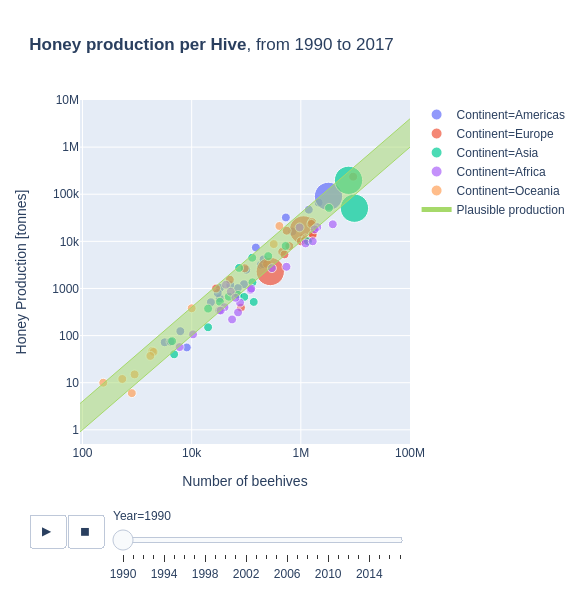

In [159]:
log = True
min_average = 10 
max_average = 40

p = px.scatter(
    beehives_honey,
    x="Number of beehives",
    y="Honey Production [tonnes]",
    title="<b>Honey production per Hive</b>, from 1990 to 2017",
    animation_frame="Year",
    animation_group="Area",
    size="Size",
    color="Continent",
    hover_name="Area",
    log_x=log,
    log_y=log,
    range_x=[90,1e8],
    range_y=[0.5,1e7],
    category_orders=dict({
        'Continent': ['Americas', 'Europe', 'Asia', 'Africa', 'Oceania']
    })
)
p.add_trace(go.Scatter(
    x=[0,1000e5],
    y=[0,min_average * 1e5],
    fill=None,
    mode='lines',
    line=dict(width=1,color='rgb(166,217,106)'),
    name="Plausible production" # TODO define what average production really is
))
p.add_trace(go.Scatter(
    x=[0,1000e5],
    y=[0,max_average * 1e5],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines',
    line=dict(width=1,color='rgb(166,217,106)'),
    showlegend=False,
))

p.show()
#plotly.offline.plot(p, filename='scatterplot_beehives_production.html', image_width=100, image_height=100);

### Beez-ness

In [160]:
exchanges = pd.merge(honey_production, exports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges = pd.merge(exchanges, imports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
exchanges["Honey Consumption"] = exchanges["Production Value"] - exchanges["Export Value"] + exchanges["Import Value"]
exchanges["Honey Capacity"] = exchanges["Import Value"] + exchanges["Production Value"]
exchanges["Balance"] = exchanges["Import Value"] - exchanges["Export Value"]
exchanges = exchanges.set_index('Year')
exchanges = exchanges.reset_index()

In [161]:
def max1(x):
    return min(max(0,x) ,1)

In [162]:
exchanges["Import Ratio"] = (exchanges["Import Value"] / exchanges["Honey Capacity"]).apply(max1)
exchanges["Export Ratio"] = (exchanges["Export Value"] / exchanges["Honey Capacity"]).apply(max1)

exchanges = exchanges.fillna(0)
exchanges["Production Value"] = exchanges["Production Value"].astype(int)

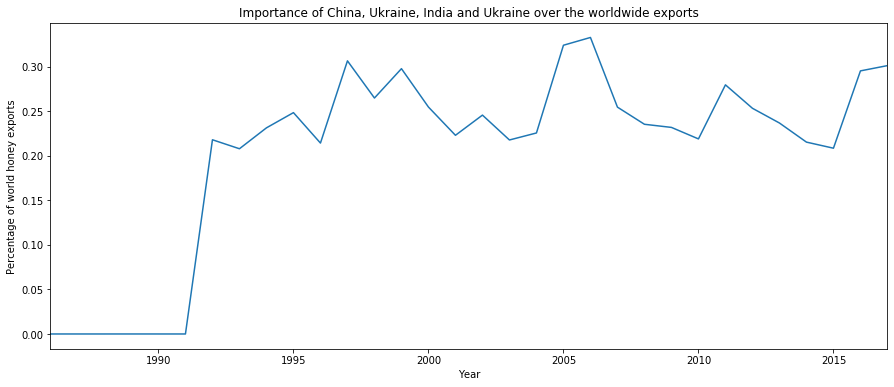

In [163]:
year = 2017

def divide_two_cols(exchanges):
    export_countries = ["China, Mainland", "Ukraine", "Argentina", "India"]
    return exchanges[(exchanges["Country"].isin(export_countries))]["Export Value"].sum()/float(exchanges["Export Value"].sum())


time_importance = exchanges.groupby("Year").apply(divide_two_cols)
plot_time_serie(time_importance, ylabel = "Percentage of world honey exports", xlabel="Year", title="Importance of China, Ukraine, India and Ukraine over the worldwide exports")

In [164]:
not_country = ["Belgium-Luxembourg", "Yugoslav SFR", "USSR", "Réunion", "Serbia and Montenegro", "Fiji"]
exchanges = exchanges[~exchanges['Country'].isin(not_country)]

In [165]:
best_countries = exchanges.groupby("Country").max()
best_countries = best_countries.sort_values("Honey Capacity", ascending = False).head(20)
countries_of_interest = best_countries.index.tolist()

In [166]:
exchanges_sc = exchanges.copy()

exchanges_sc = exchanges_sc[exchanges_sc["Country"].isin(countries_of_interest)]
exchanges_sc = exchanges_sc[exchanges_sc["Year"] >= 1990]
   
exchanges_sc["Continent"] = exchanges_sc.apply(lambda row: countries.loc[row['Country']], axis=1)
   
exchanges_sc = exchanges_sc.sort_values(["Year", "Country"])

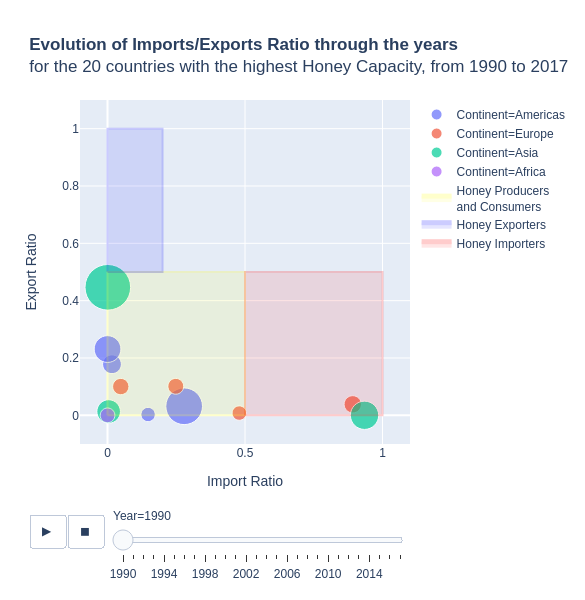

In [167]:
p = px.scatter(exchanges_sc, x="Import Ratio", y="Export Ratio", animation_frame="Year", animation_group="Country",
           size="Honey Capacity", color="Continent", hover_name="Country", 
               title = "<b>Evolution of Imports/Exports Ratio through the years</b><br>for the 20 countries with the highest Honey Capacity, from 1990 to 2017",
        size_max=55, range_x=[-0.1,1.1], range_y=[-0.1,1.1], category_orders=dict({
    'Continent': ['Americas', 'Europe', 'Asia', 'Africa', 'Oceania']
}))

p.add_trace(go.Scatter(
    x=[0,0.5,0.5,0,0],
    y=[0,0,0.5,0.5,0],
    fill='toself',
    hoverinfo='skip',
    opacity = 0.2,
    mode='lines',
    line_color='yellow',
    name="Honey Producers<br>and Consumers"
))

p.add_trace(go.Scatter(
    x=[0,0.2,0.2,0,0],
    y=[0.5,0.5,1,1,0.5],
    fill='toself',
    opacity = 0.2,
    hoverinfo='skip',
    mode='lines',
    line_color='blue',
    name="Honey Exporters" # TODO define what average production really is
))

p.add_trace(go.Scatter(
    x=[0.5,1,1,0.5,0.5],
    y=[0,0,0.5,0.5,0],
    fill='toself',
    opacity = 0.2,
    hoverinfo='skip',
    mode='lines',
    line_color='red',
    name="Honey Importers" # TODO define what average production really is
))

p.show()
#plotly.offline.plot(p, filename='beezness_plot.html')